In [1]:
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch
from sklearn import linear_model



from sngrok.cosets import get_left_cosets, get_right_cosets, make_left_full_coset_df, make_right_full_coset_df

from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [2]:
from torch.nn.functional import relu
from copy import deepcopy


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def mean_ablate_one_column(model, linear_activations, index):
    
    act_means = relu(linear_activations).mean(0)
    
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = act_means[index]
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()




def perturb_acts(model, linear_activations, mu, sigma):
    mean = torch.full_like(linear_activations, mu)
    var = torch.full_like(linear_activations, sigma)
    
    acts = deepcopy(relu(linear_activations + torch.normal(mean, var)))

    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()


def eval_loss(model_fn, params, lperms, rperms, targets):
    logits = model_fn(params, lperms, rperms)
    return loss_fn(logits, targets).mean()


def full_ablations(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    
    original_loss = loss_fn(logits, targets).mean()
    
    linear_acts = cache['hook_linear']
    
    perturbed_loss001 =  perturb_acts(model, linear_acts, 0.0, 0.1)
    perturbed_loss01 = perturb_acts(model, linear_acts, 0.0, 1.0)
    perturbed_loss11 = perturb_acts(model, linear_acts, 1.0, 1.0)
    perturbed_lossneg11 = perturb_acts(model, linear_acts, -1.0, 1.0)
    
    abs_logits = model.unembed(linear_acts.abs())
    abs_loss = loss_fn(abs_logits, targets).mean()
    
    full_sign_logits = model.unembed(relu(-1. * linear_acts))
    full_sign_loss = loss_fn(full_sign_logits, targets).mean()
    
    fmodel, params = functorch.make_functional(model)
    
    fparams = [deepcopy(p) for p in params]
    fparams[0] = -1.0 * params[0]
    
    left_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    fparams = [deepcopy(p) for p in params]
    fparams[1] = -1.0 * params[1]
    
    right_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    return {
        'model_seed': model_seed,
        'original_loss': original_loss.item(),
        'full_sign_loss': full_sign_loss.item(),
        'abs_loss': abs_loss.item(),
        'left_sign_loss':  left_sign_loss.item(),
        'right_sign_loss': right_sign_loss.item(),
        'perturbed_loss_mean0_var1': perturbed_loss01.item(),
        'perturbed_loss_mean0_var0.1': perturbed_loss001.item(),
        'perturbed_loss_mean1_var1': perturbed_loss11.item(),
        'perturbed_loss_mean-1_var1': perturbed_lossneg11.item(),
    }



def fourier_basis_to_df(tensor, n, layer):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'layer': [layer] * len(group_col), 'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')
    
#ablation_data = []

#for i in range(128):
#    ablation_data.append(full_ablations(i))

#loss_data = pl.DataFrame(ablation_data, orient='row')

In [3]:
#(
#    loss_data
#    
#    .rename({
#        'perturbed_loss_mean0_var1': 'pert_mean0_var1',
#        'perturbed_loss_mean0_var0.1': 'pert_mean0_var01',
#        'perturbed_loss_mean1_var1': 'pert_mean1_var1',
#        'perturbed_loss_mean-1_var1': 'pert_mean-1_var1'
#    })
#    .melt(id_vars='model_seed')
#    .groupby('variable')
#    .agg(
#        min_loss = pl.col('value').min(),
#        mean_loss = pl.col('value').mean(),
#        max_loss = pl.col('value').max(),
#        median_loss = pl.col('value').median(),
#        std_loss = pl.col('value').std(),
#        loss05 = pl.col('value').quantile(0.05),
#        loss10 = pl.col('value').quantile(0.10),
#        loss20 = pl.col('value').quantile(0.20),
#        loss40 = pl.col('value').quantile(0.40),
#        loss60 = pl.col('value').quantile(0.60),
#        loss80 = pl.col('value').quantile(0.80),
#        loss90 = pl.col('value').quantile(0.90),
#        loss95 = pl.col('value').quantile(0.95),
#    )
#    .sort('variable')   
#)

In [4]:
#from plotnine import scale_y_log10

#(
#    ggplot(
#        loss_data.select(pl.exclude('abs_loss')).melt(id_vars='model_seed'), 
#        aes(x='variable', y='value')
#    ) 
#    + geom_boxplot() 
#    + scale_y_log10()
#    + theme(axis_text_x=element_text(rotation=60, hjust=1))
#)

In [5]:
def fourier_stats(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'
    S5 = Symmetric(5)

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    config = model_run['config']
    embed_dim = config['embed_dim']

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    unembed_power_df, unembed_ft = calc_power_contributions(model.unembed.weight, 5)
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    unembed_power_df.insert_at_idx(0, pl.Series('layer', ['unembed'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df, unembed_power_df], how='vertical').melt(id_vars=['layer', 'irrep'])
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    unembed_decomp = sn_fourier_basis(unembed_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    unembed_df = fourier_basis_to_df(unembed_decomp, 5, 'unembed')
        
    
    return llinear_df, rlinear_df, unembed_df, power_df 
    


In [9]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(36)

In [16]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(36)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())

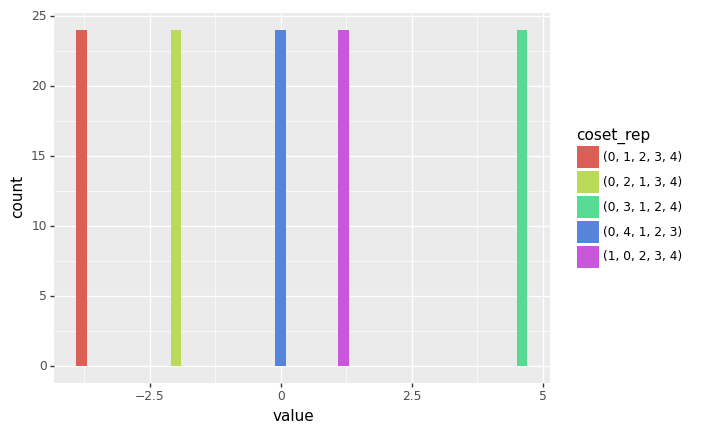

<ggplot: (703339725)>

In [17]:
df = (
    left_base_df
    .join(full_right_coset_df.filter(pl.col('subgroup') == 's4_1'), on='permutation', how='inner')
   
)

ggplot(df.filter(pl.col('variable') == 'dim0'), aes(x='value', fill='coset_rep')) + geom_histogram(binwidth=0.2)

In [18]:
df.filter(pl.col('variable') == 'dim0').groupby('coset_rep').agg(pl.col('value').var())

coset_rep,value
str,f32
"""(0, 4, 1, 2, 3…",5.2692e-7
"""(0, 1, 2, 3, 4…",1.0651e-7
"""(1, 0, 2, 3, 4…",3.7987e-7
"""(0, 2, 1, 3, 4…",4.5178e-7
"""(0, 3, 1, 2, 4…",4.8595e-7


In [19]:
(
    left_base_df
    .join(full_right_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation', how='inner')
   
)

layer,permutation,variable,value,subgroup,coset_rep
str,str,str,f32,str,str
"""left_linear""","""(0, 4, 3, 2, 1…","""dim0""",-0.02683,"""s4_0""","""(0, 1, 2, 3, 4…"
"""left_linear""","""(1, 0, 2, 4, 3…","""dim0""",1.2116,"""s4_0""","""(1, 0, 2, 3, 4…"
"""left_linear""","""(1, 2, 3, 4, 0…","""dim0""",-1.923103,"""s4_0""","""(1, 0, 2, 3, 4…"
"""left_linear""","""(1, 3, 0, 4, 2…","""dim0""",4.552602,"""s4_0""","""(1, 0, 2, 3, 4…"
"""left_linear""","""(1, 3, 2, 0, 4…","""dim0""",4.55222,"""s4_0""","""(1, 0, 2, 3, 4…"
"""left_linear""","""(2, 3, 4, 0, 1…","""dim0""",4.552639,"""s4_0""","""(2, 0, 1, 3, 4…"
"""left_linear""","""(4, 1, 3, 2, 0…","""dim0""",-3.801167,"""s4_0""","""(4, 0, 1, 2, 3…"
"""left_linear""","""(0, 1, 4, 3, 2…","""dim0""",-3.800947,"""s4_0""","""(0, 1, 2, 3, 4…"
"""left_linear""","""(0, 2, 1, 3, 4…","""dim0""",-1.923277,"""s4_0""","""(0, 1, 2, 3, 4…"


In [20]:
#base_df.join(s4_right_coset_df.melt(id_vars='permutation'))
(
    left_base_df
    .join(full_right_coset_df, on='permutation', how='inner')
    .groupby(['layer', 'variable', 'subgroup', 'coset_rep'])
    .agg([
        pl.col('value').var().alias('coset_var'),
        pl.col('value').mean().alias('coset_mean')
    ])
    
    .groupby(['layer', 'variable', 'subgroup'], maintain_order=True)
    .agg([
        pl.col('coset_var').sum().alias('coset_cond_var'),
    ])
    .sort(['variable', 'coset_cond_var'])
    .groupby(['layer', 'variable'], maintain_order=True)
    .agg([
        pl.col('subgroup').first(),
        pl.col('coset_cond_var').first().alias('min_coset_var'),
        (pl.col('coset_cond_var').mean() - pl.col('coset_cond_var').first()).alias('sanity')
    ])
).sort('variable').filter(pl.col('subgroup') == 'a5')

layer,variable,subgroup,min_coset_var,sanity
str,str,str,f32,f32


In [6]:
from sngrok.proper_subgroups import  all_s5_subgroups

def _all_data_coset_analysis(data, coset_df):
    base_df = (
        data
        .melt(id_vars=['layer', 'permutation', 'irrep'])
        .groupby(['layer', 'permutation', 'variable'])
        .agg(pl.col('value').sum())
    )
    summary_df = (
        base_df
        .groupby(['layer', 'variable'])
        .agg([
            pl.col('value').mean().alias('mean'),
            pl.col('value').min().alias('min'),
            pl.col('value').max().alias('max'),
            pl.col('value').var().alias('full_var'),
            (pl.col('value') ** 2).sum().alias('two_norm')
        ])
    )
    
    df = (
        base_df
        ##### Join against _all_ cosets, this is a many-to-1 join
        .join(coset_df, on='permutation', how='inner')
        .groupby(['layer', 'variable', 'subgroup', 'coset_rep'])
        .agg([
            # Get the average value and variance of the (per dim) activations over a single coset
            # Small variance --> activations highly concentrated on the coset
            pl.col('value').var().alias('coset_var'),
            pl.col('value').mean().alias('coset_mean')
        ])
        .sort(['variable', 'subgroup', 'coset_rep'])
        .groupby(['layer', 'variable', 'subgroup'], maintain_order=True)
        # Sum all the variances of the cosets for one subgroup
        .agg(pl.col('coset_var').sum().alias('coset_cond_var'))
        # Sort ascending by coset variance
        .sort(['variable', 'coset_cond_var'])
        .groupby(['layer', 'variable'], maintain_order=True)
        .agg([
            # 
            pl.col('subgroup').first(),
            pl.col('coset_cond_var').first().alias('min_coset_var'),
        ])
        .join(summary_df, on=['layer', 'variable'])
        .sort('subgroup')
        .with_columns(
            coset_var_ratio = (pl.col('min_coset_var') / pl.col('full_var')),
            subgroup_class = pl.col('subgroup').str.split(by='_').list.get(0)
        )
    )
    return df


def _irrep_coset_analysis(data, coset_df):
    base_df = (
        data
        .melt(id_vars=['layer', 'permutation', 'irrep'])
    )
    summary_df = (
        base_df
        .groupby(['layer', 'variable', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean'),
            pl.col('value').min().alias('min'),
            pl.col('value').max().alias('max'),
            pl.col('value').var().alias('full_var'),
            (pl.col('value') ** 2).sum().alias('two_norm')
        ])
    )
    df = (
        base_df
        ##### Join against _all_ cosets, this is a many-to-1 join
        .join(coset_df, on='permutation', how='inner')
        .groupby(['layer', 'variable', 'irrep', 'subgroup', 'coset_rep'])
        .agg([
            # Get the average value and variance of the (per dim) activations over a single coset
            # Small variance --> activations highly concentrated on the coset
            pl.col('value').var().alias('coset_var'),
            pl.col('value').mean().alias('coset_mean')
        ])
        .sort(['variable', 'subgroup', 'coset_rep', 'irrep'])
        .groupby(['layer', 'variable', 'subgroup', 'irrep'], maintain_order=True)
        # Sum all the variances of the cosets for one subgroup
        .agg(pl.col('coset_var').sum().alias('coset_cond_var'))
        # Sort ascending by coset variance
        .sort(['variable', 'coset_cond_var'])
        .groupby(['layer', 'variable', 'irrep'], maintain_order=True)
        .agg([
            pl.col('subgroup').first().alias('min_var_subgroup'),
            pl.col('coset_cond_var').first().alias('min_coset_var'),
        ])
        .join(summary_df, on=['layer', 'variable', 'irrep'])
        .with_columns(
            coset_var_ratio = (pl.col('min_coset_var') / pl.col('full_var')),
            subgroup_class = pl.col('min_var_subgroup').str.split(by='_').list.get(0)
        )
        .with_columns(
            pl.when(pl.col('two_norm') < 1.0)
            .then(pl.lit('Off'))
            .when(pl.col('min_coset_var') < 1.0)
            .then(pl.col('min_var_subgroup'))
            .otherwise(pl.lit('None'))
            .alias('neuron_classification')
        )
    )
    return df
    
        

def _make_one_coset_df(sg_def, n, name):
        all_subgroups = [generate_subgroup(gen) for gen in sg_def['generators']]
        right_coset_df = make_right_full_coset_df(all_subgroups, n, name)
        left_coset_df = make_left_full_coset_df(all_subgroups, n, name)
        return left_coset_df, right_coset_df
        
        

def make_full_coset_df(all_subgroups, n):
        left_cosets = []
        right_cosets = []
        
        for subgroup_name, subgroup_info in all_subgroups.items():
            ldf, rdf =  _make_one_coset_df(subgroup_info, n, subgroup_name)
            left_cosets.append(ldf)
            right_cosets.append(rdf)

        left_df = pl.concat(left_cosets)
        right_df = pl.concat(right_cosets)
        
        return left_df, right_df
                


def transpose_power_df(data):
    irreps = data['irrep'].to_list()
    return (
        data
        .select(pl.exclude('irrep'))
        .transpose(
            include_header=True,
            header_name='variable', 
            column_names=irreps)
    )


def fp_sort_key(fp):
    last_part = fp.parts[-1].strip('.pth')
    if last_part == 'full_run':
        return 2 ** 10000
    else:
        return int(last_part)
    
    
def _analysis(model_run, perms, full_left_coset_df, full_right_coset_df):
    lperms, rperms, targets = perms
    
    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    original_loss = loss_fn(logits, targets)
    
    linear_acts = cache['hook_linear']
    S5 = Symmetric(5)
    
    config = model_run['config']
    embed_dim = config['embed_dim']
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    
        
    #lpower_df = transpose_power_df(lpower_df)
    #rpower_df = transpose_power_df(rpower_df)
    
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df], how='vertical')
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df(all_s5_subgroups, 5)

    left_perm_coset_df = _all_data_coset_analysis(llinear_df, full_right_coset_df)
    right_perm_coset_df = _all_data_coset_analysis(rlinear_df, full_left_coset_df)


    return left_perm_coset_df, right_perm_coset_df
    

def cosets_over_time(model_seed):
    ckpt_dir = Path('/Users/dashiell/s5_50_medium')
    output_dir = Path('/Users/dashiell/Documents/sn-circuits/medium')
    run_name = f's5_50_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    full_left_coset_df, full_right_coset_df = make_full_coset_df(all_s5_subgroups, 5)
    #full_left_coset_df = full_left_coset_df.lazy()
    #full_right_coset_df = full_right_coset_df.lazy()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    left_data = []
    right_data = []
    
    for epoch, ckpt_fp in zip(checkpoint_epochs, checkpoint_paths):
        ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
        left_perm_coset_df, right_perm_coset_df = _analysis(
            ckpt,
            (lperms, rperms, targets),
            full_left_coset_df,
            full_right_coset_df
        )
        left_perm_coset_df.insert_at_idx(0, pl.Series('epoch', [epoch] * left_perm_coset_df.shape[0]))
        right_perm_coset_df.insert_at_idx(0, pl.Series('epoch', [epoch] * right_perm_coset_df.shape[0]))
        left_data.append(left_perm_coset_df)
        right_data.append(right_perm_coset_df)
             
    pl.concat(left_data, how='vertical').write_parquet(output_dir / f'left_cosets/{model_seed}.parquet')
    pl.concat(right_data, how='vertical').write_parquet(output_dir / f'right_cosets/{model_seed}.parquet')

    

In [118]:
def get_linear_layer_decomp(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    model = SnMLP.from_config(full_run['config'])
    model.load_state_dict(full_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(logits, targets)

    linear_acts = cache['hook_linear']
    df = pl.concat(
        [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(linear_acts.shape[1])])],
        how='horizontal'
    )
    return df.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
    

In [8]:
def basic_analysis(model_run, perms, epoch):
    lperms, rperms, targets = perms
    
    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    original_loss = loss_fn(logits, targets)
    
    linear_acts = cache['hook_linear']
    S5 = Symmetric(5)
    
    config = model_run['config']
    embed_dim = config['embed_dim']
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    upower_df, unembed_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    
        
    #lpower_df = transpose_power_df(lpower_df)
    #rpower_df = transpose_power_df(rpower_df)
    
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    upower_df.insert_at_idx(0, pl.Series('layer', ['unembed'] * upower_df.shape[0]))
    power_df = pl.concat([lpower_df, rpower_df, upower_df], how='vertical')
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    unembed_decomp = sn_fourier_basis(unembed_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    unembed_df = fourier_basis_to_df(unembed_decomp, 5, 'unembed')
    
    llinear_df.insert_at_idx(0, pl.Series('epoch', [epoch] * llinear_df.shape[0]))
    rlinear_df.insert_at_idx(0, pl.Series('epoch', [epoch] * rlinear_df.shape[0]))
    unembed_df.insert_at_idx(0, pl.Series('epoch', [epoch] * unembed_df.shape[0]))
    
    return power_df, llinear_df, rlinear_df, unembed_df
    
    
    
def tensor_to_parquet(model_seed):
    ckpt_dir = Path('/Users/dashiell/s5_50_medium')
    output_dir = Path('/Users/dashiell/Documents/sn-circuits/medium')
    run_name = f's5_50_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df(all_s5_subgroups, 5)
    #full_left_coset_df = full_left_coset_df.lazy()
    #full_right_coset_df = full_right_coset_df.lazy()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    
    left_linear = []
    right_linear = []
    unembed = []
    power = []
    
    
    for epoch, ckpt_fp in zip(checkpoint_epochs, checkpoint_paths):
        ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
        power_df, llinear_df, rlinear_df, unembed_df = basic_analysis(ckpt, (lperms, rperms, targets), epoch)
        power_df.insert_at_idx(0, pl.Series('seed', [model_seed] * power_df.shape[0]))
        llinear_df.insert_at_idx(0, pl.Series('seed', [model_seed] * llinear_df.shape[0]))
        rlinear_df.insert_at_idx(0, pl.Series('seed', [model_seed] * rlinear_df.shape[0]))
        unembed_df.insert_at_idx(0, pl.Series('seed', [model_seed] * unembed_df.shape[0]))
        
        left_linear.append(llinear_df)
        right_linear.append(llinear_df)
        unembed.append(unembed_df)
        power.append(power_df)
        
        
    pl.concat(left_linear).write_parquet(output_dir / f's5_medium_left_linear/{model_seed}.parquet')
    pl.concat(right_linear).write_parquet(output_dir / f's5_medium_right_linear/{model_seed}.parquet')
    pl.concat(unembed).write_parquet(output_dir / f's5_medium_unembed/{model_seed}.parquet')
    pl.concat(power).write_parquet(output_dir / f's5_medium_power/{model_seed}.parquet')
    

In [12]:
#for i in range(128):
#    tensor_to_parquet(i)

In [24]:
#merged_df, irrep_df = cosets_over_time(0)

In [9]:
def _all_data_coset_analysis(data, coset_df):
    base_df = (
        data
        .melt(id_vars=['seed', 'epoch', 'layer', 'permutation', 'irrep'])
        .groupby(['seed', 'epoch', 'layer', 'permutation', 'variable'])
        .agg(pl.col('value').sum())
    )
    summary_df = (
        base_df
        .groupby(['seed', 'epoch', 'layer', 'variable'])
        .agg([
            pl.col('value').mean().alias('mean'),
            pl.col('value').min().alias('min'),
            pl.col('value').max().alias('max'),
            pl.col('value').var().alias('full_var'),
            (pl.col('value') ** 2).sum().alias('two_norm')
        ])
    )
    
    df = (
        base_df
        ##### Join against _all_ cosets, this is a many-to-1 join
        .join(coset_df, on='permutation', how='inner')
        .groupby(['seed', 'epoch', 'layer', 'variable', 'subgroup', 'coset_rep'])
        .agg([
            # Get the average value and variance of the (per dim) activations over a single coset
            # Small variance --> activations highly concentrated on the coset
            pl.col('value').var().alias('coset_var'),
            pl.col('value').mean().alias('coset_mean')
        ])
        .sort(['seed', 'epoch', 'variable', 'subgroup', 'coset_rep'])
        .groupby(['seed', 'epoch', 'layer', 'variable', 'subgroup'], maintain_order=True)
        # Sum all the variances of the cosets for one subgroup
        .agg(pl.col('coset_var').sum().alias('coset_cond_var'))
        # Sort ascending by coset variance
        .sort(['variable', 'coset_cond_var'])
        .groupby(['seed', 'epoch', 'layer', 'variable'], maintain_order=True)
        .agg([
            # 
            pl.col('subgroup').first().alias('min_var_subgroup'),
            pl.col('coset_cond_var').first().alias('min_coset_var'),
        ])
        .join(summary_df, on=['seed', 'epoch', 'layer', 'variable'])
        .with_columns(
            coset_var_ratio = (pl.col('min_coset_var') / pl.col('full_var')),
            subgroup_class = pl.col('min_var_subgroup').str.split(by='_').list.get(0)
        )
        .with_columns(
            pl.when(pl.col('two_norm') < 1.0)
            .then(pl.lit('Off'))
            .when(pl.col('min_coset_var') < 1.0)
            .then(pl.col('min_var_subgroup'))
            .otherwise(pl.lit('None'))
            .alias('neuron_classification')
        )
    )
    return df



ll_df = pl.scan_parquet(Path('/Users/dashiell/Documents/sn-circuits/small/s5_small_left_linear/*.parquet'))
    

In [10]:
full_left_coset_df, full_right_coset_df = make_full_coset_df(all_s5_subgroups, 5)
#full_right_coset_df = full_right_coset_df.lazy()
#full_left_coset_df = full_left_coset_df.lazy()

In [62]:
from tqdm.notebook import tqdm


#for i in tqdm(range(0, 128)):
#    cosets_over_time(i)

  0%|          | 0/128 [00:00<?, ?it/s]

In [31]:
def add_neuron_classification(data):
    return (
        data.
        with_columns(
            pl.when(pl.col('two_norm') < 1.0)
            .then(pl.lit('Off'))
            .when(pl.col('coset_var_ratio') < 1.0)
            .then(pl.col('subgroup'))
            .otherwise(pl.lit('None'))
            .alias('neuron_classification')
        )
    )

In [32]:
small_coset_path = Path('/Users/dashiell/Documents/sn-circuits/small/')

cols = ['epoch', 'layer', 'variable', 'subgroup', 'min_coset_var', 'coset_var_ratio', 'full_var', 'two_norm', 'subgroup_class', 'neuron_classification']


small_coset_data = []

for i in range(128):
    left = pl.scan_parquet(small_coset_path / f'left_cosets/{i}.parquet')
    right = pl.scan_parquet(small_coset_path / f'right_cosets/{i}.parquet')
    
    left = add_neuron_classification(left).select(cols).rename({
        'subgroup': 'left_subgroup',
        'min_coset_var': 'left_min_coset_var',
        'coset_var_ratio': 'left_coset_var_ratio',
        'full_var': 'left_full_var',
        'two_norm': 'left_two_norm', 
        'subgroup_class': 'left_subgroup_class', 
        'neuron_classification': 'left_neuron_classification'
    })
    right = add_neuron_classification(right).rename({
        'subgroup': 'right_subgroup',
        'min_coset_var': 'right_min_coset_var',
        'coset_var_ratio': 'right_coset_var_ratio',
        'full_var': 'right_full_var',
        'two_norm': 'right_two_norm', 
        'subgroup_class': 'right_subgroup_class', 
        'neuron_classification': 'right_neuron_classification'
    })
    merged = left.join(right, on=['epoch', 'variable'])
    data = merged.collect()
    data.insert_at_idx(0, pl.Series('seed', [i] * data.shape[0]))
    small_coset_data.append(data)
                                
small_coset_df = pl.concat(small_coset_data)

cosets_data = (
    small_coset_df.with_columns(
        left_neuron_class = pl.col('left_neuron_classification').str.split(by='_').list.get(0),
        right_neuron_class = pl.col('right_neuron_classification').str.split(by='_').list.get(0),
        neuron_class_pair = '(' + pl.col('left_neuron_classification') + ', ' + pl.col('right_neuron_classification') + ')'
    )
)

In [43]:
cosets_data = (
    small_coset_df.with_columns(
        left_neuron_class = pl.col('left_neuron_classification').str.split(by='_').list.get(0),
        right_neuron_class = pl.col('right_neuron_classification').str.split(by='_').list.get(0),
        neuron_class_pair = '(' + pl.col('left_neuron_classification') + ', ' + pl.col('right_neuron_classification') + ')'
    )
)



In [59]:
df = (
    cosets_data
    .filter(pl.col('left_neuron_class') == pl.col('right_neuron_class'))
    .filter(pl.col('left_neuron_class') == 'A4')
    .groupby(['epoch', 'seed', 'left_neuron_class']).agg(
        count = pl.count(),
        pcnt = pl.count() / 128,
    )
)



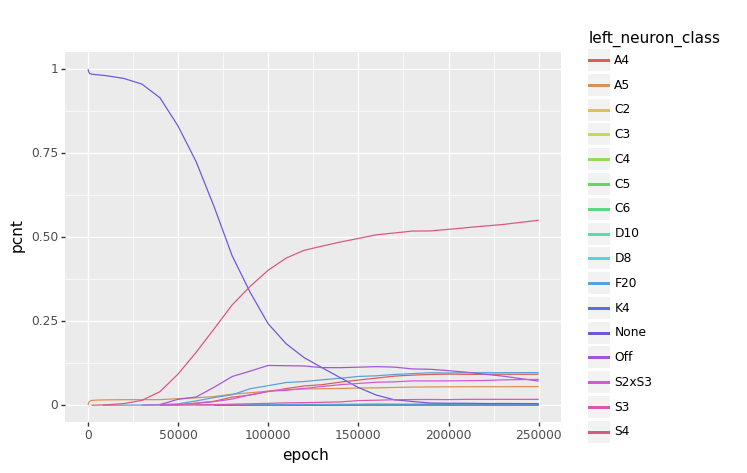

<ggplot: (368018508)>

In [210]:
 df = (
     cosets_data
     .filter(pl.col('left_neuron_class') == pl.col('right_neuron_class'))
     .groupby(['epoch', 'left_neuron_class']).agg(
         pl.count()
     )
     .with_columns(pcnt=pl.col('count') / 128**2)
     #.filter(pl.col('left_neuron_class').is_in(['A4', 'A5', 'S5', 'F20', 'S2xS3', 'S3', 'S4', 'D8']))
)
    
    
ggplot(df, aes(x='epoch',y='pcnt', color='left_neuron_class')) + geom_line() 

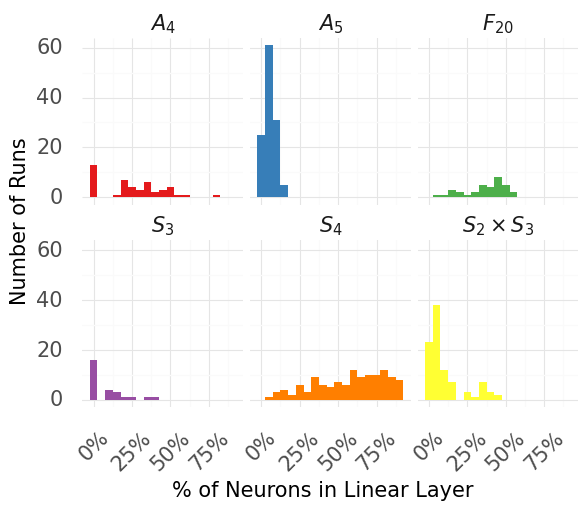

<ggplot: (370918467)>

In [211]:
from mizani.palettes import brewer_pal
from plotnine import scale_fill_brewer, element_text, theme_minimal, scale_x_continuous, labs
from mizani.formatters import percent_format

sg_names = {
    'A4': '$A_4$',
    'A5': '$A_5$',
    'F20': '$F_{20}$',
    'S2xS3': '$S_{2} \\times S_{3}$',
    'S3': '$S_3$',
    'S4': '$S_4$'
}


df = (
     cosets_data
     .filter(pl.col('left_neuron_class') == pl.col('right_neuron_class'))
     .filter(pl.col('epoch') == 249999)
     .groupby([ 'seed', 'left_neuron_class']).agg(
         pl.count()
     )
     .with_columns(pcnt=pl.col('count')/128.0)
     .filter(pl.col('left_neuron_class').is_in(['A4', 'A5', 'F20', 'S2xS3', 'S3', 'S4']))
     .with_columns(
         subgroup = pl.col('left_neuron_class').map_dict(sg_names)
     )
)
    
(
    ggplot(df, aes(x='pcnt', fill='subgroup'))
    + geom_histogram(binwidth=0.05, show_legend=False) 
    + facet_wrap('~subgroup')
    + theme_minimal()
    + theme(text=element_text(size=15), axis_text_x=element_text(angle=45))
    + scale_x_continuous(labels=percent_format())
    + scale_fill_brewer(type='qual', palette=6)
    + labs(x = '% of Neurons in Linear Layer', y = 'Number of Runs', fill='Subgroup')
)



In [93]:
df.filter(pl.col('left_neuron_class') == 'None').sort('pcnt')
# 75, 64, 67

lots_nones = (
    cosets_data
    .filter((pl.col('epoch') == 249999) & (pl.col('seed') == 67))
    .filter(pl.col('left_neuron_class') == pl.col('right_neuron_class'))
    .filter(pl.col('left_neuron_class') == 'None')
)
lots_nones['variable'].to_list()

['dim62',
 'dim78',
 'dim91',
 'dim92',
 'dim11',
 'dim85',
 'dim102',
 'dim124',
 'dim38',
 'dim75',
 'dim82',
 'dim21',
 'dim49',
 'dim64',
 'dim70',
 'dim74',
 'dim33',
 'dim55',
 'dim109',
 'dim2',
 'dim39',
 'dim100',
 'dim122',
 'dim24',
 'dim28',
 'dim67',
 'dim121']

In [213]:
2 ** (2 ** 8)

115792089237316195423570985008687907853269984665640564039457584007913129639936

In [91]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(67)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())


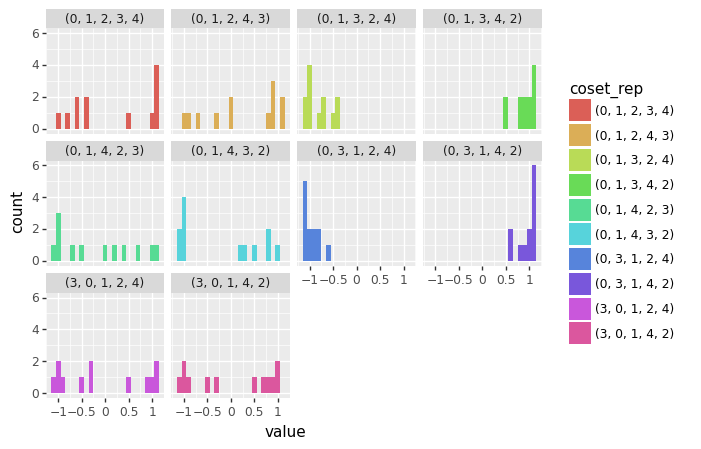

<ggplot: (689871788)>

In [157]:
col = 'dim67'
sg = 'A4_3'

df = (
    right_base_df.filter(pl.col('variable') == col)
    .join(full_left_coset_df.filter(pl.col('subgroup') == sg), on='permutation')
)


ggplot(df, aes(x='value', fill='coset_rep')) + geom_histogram(binwidth=0.1) + facet_wrap('~coset_rep')

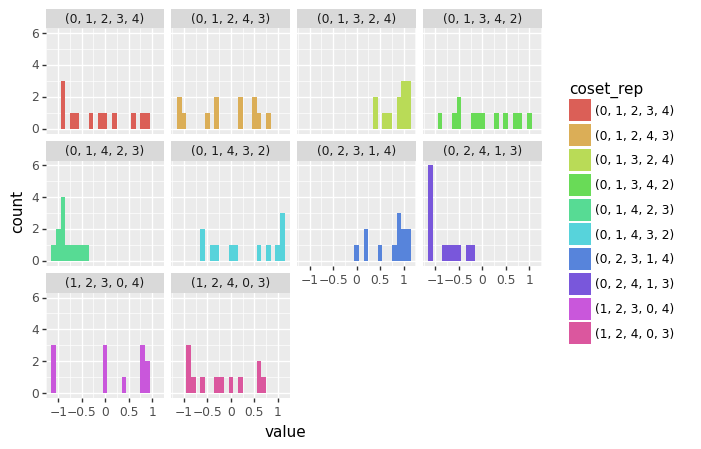

<ggplot: (370748404)>

In [166]:
col = 'dim67'
sg = 'A4_3'

df = (
    left_base_df.filter(pl.col('variable') == col)
    .join(full_right_coset_df.filter(pl.col('subgroup') == sg), on='permutation')
)


ggplot(df, aes(x='value', fill='coset_rep')) + geom_histogram(binwidth=0.1) + facet_wrap('~coset_rep')

In [119]:
preact_df67 = get_linear_layer_decomp(67)

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 33'. Pick better value with 'binwidth'.


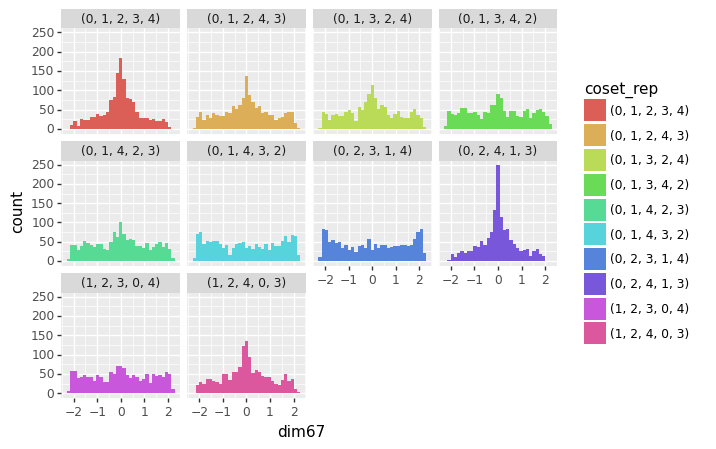

<ggplot: (369564330)>

In [127]:
col = 'dim67'
sg = 'A4_3'
df = (
    preact_df67.select(['permutation_target', col])
    .join(full_right_coset_df.filter(pl.col('subgroup') == sg), left_on='permutation_target', right_on='permutation')
)

ggplot(df, aes(x = col, fill = 'coset_rep')) + geom_histogram() + facet_wrap('~coset_rep')

In [217]:
med_coset_path = Path('/Users/dashiell/Documents/sn-circuits/medium/')

cols = ['epoch', 'layer', 'variable', 'subgroup', 'min_coset_var', 'coset_var_ratio', 'full_var', 'two_norm', 'subgroup_class', 'neuron_classification']


med_coset_data = []

for i in range(128):
    left = pl.scan_parquet(med_coset_path / f'left_cosets/{i}.parquet')
    right = pl.scan_parquet(med_coset_path / f'right_cosets/{i}.parquet')
    
    left = add_neuron_classification(left).select(cols).rename({
        'subgroup': 'left_subgroup',
        'min_coset_var': 'left_min_coset_var',
        'coset_var_ratio': 'left_coset_var_ratio',
        'full_var': 'left_full_var',
        'two_norm': 'left_two_norm', 
        'subgroup_class': 'left_subgroup_class', 
        'neuron_classification': 'left_neuron_classification'
    })
    right = add_neuron_classification(right).rename({
        'subgroup': 'right_subgroup',
        'min_coset_var': 'right_min_coset_var',
        'coset_var_ratio': 'right_coset_var_ratio',
        'full_var': 'right_full_var',
        'two_norm': 'right_two_norm', 
        'subgroup_class': 'right_subgroup_class', 
        'neuron_classification': 'right_neuron_classification'
    })
    merged = left.join(right, on=['epoch', 'variable'])
    data = merged.collect()
    data.insert_at_idx(0, pl.Series('seed', [i] * data.shape[0]))
    med_coset_data.append(data)
                                
med_coset_df = pl.concat(med_coset_data)

cosets_data = (
    med_coset_df.with_columns(
        left_neuron_class = pl.col('left_neuron_classification').str.split(by='_').list.get(0),
        right_neuron_class = pl.col('right_neuron_classification').str.split(by='_').list.get(0),
        neuron_class_pair = '(' + pl.col('left_neuron_classification') + ', ' + pl.col('right_neuron_classification') + ')'
    )
)

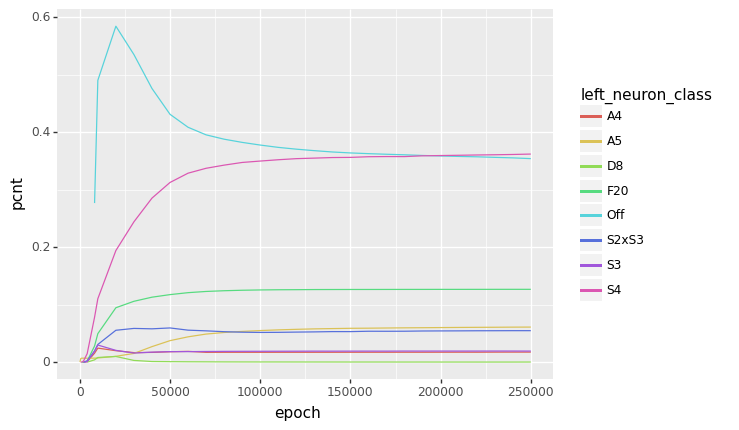

<ggplot: (361137924)>

In [225]:
 df = (
     cosets_data
     .filter(pl.col('left_neuron_class') == pl.col('right_neuron_class'))
     .groupby(['epoch', 'left_neuron_class']).agg(
         pl.count()
     )
     .with_columns(pcnt=pl.col('count') / (128 * 1024))
     .filter(pl.col('left_neuron_class').is_in(['A4', 'A5', 'S5', 'F20', 'S2xS3', 'S3', 'S4', 'D8', 'Off']))
)
    
    
ggplot(df, aes(x='epoch',y='pcnt', color='left_neuron_class')) + geom_line() 

In [216]:
#med_left_cosets = pl.scan_parquet(Path('/Users/dashiell/Documents/sn-circuits/medium/left_cosets/*.parquet'))
#med_right_cosets = pl.scan_parquet(Path('/Users/dashiell/Documents/sn-circuits/medium/right_cosets/*.parquet'))


In [26]:
data.filter((pl.col('coset_var_ratio') < 1.0)).groupby(['seed', 'epoch', 'subgroup_class']).count().sort(['epoch', 'subgroup_class']).collect()

seed,epoch,subgroup_class,count
i64,i64,str,u32
1,10000,"""A5""",2
1,20000,"""A5""",2
1,20000,"""S4""",2
1,30000,"""A5""",2
1,30000,"""S4""",9
1,40000,"""A5""",2
1,40000,"""S3""",1
1,40000,"""S4""",39


In [103]:
merged_df.filter((pl.col('epoch') == 249999)).groupby('subgroup_class').count()


#irrep_df.filter(pl.col('variable') == 'dim90').sort(['epoch', 'irrep'])

subgroup_class,count
str,u32
"""mixed""",1
"""S4""",98
"""S2xS3""",9
"""C2""",5
"""A4""",4
"""A5""",11


In [105]:
merged_df.filter((pl.col('epoch') == 249999) & (pl.col('subgroup_class') == 'A4'))


epoch,layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
249999,"""left_linear""","""dim26""","""A4_0""",0.0,1.9233e-30,-4.3385e-25,4.3385e-25,0.0,0.0,NaN,"""A4""","""right_linear""","""A4_0""",0.0,-1.2005e-30,-4.3387e-25,4.3392e-25,0.0,0.0,NaN,"""A4""","""(A4_0, A4_0)""",0.0,NaN,0.0,"""A4"""
249999,"""left_linear""","""dim56""","""A4_0""",0.0,-9.6840e-40,-5.0388e-35,5.1889e-35,0.0,0.0,NaN,"""A4""","""right_linear""","""A4_0""",0.0,-2.3156e-39,-6.1462e-35,6.0019e-35,0.0,0.0,NaN,"""A4""","""(A4_0, A4_0)""",0.0,NaN,0.0,"""A4"""
249999,"""left_linear""","""dim12""","""A4_0""",2.3786e-8,0.000001,-0.624274,0.624125,0.130133,15.485819,1.8278e-7,"""A4""","""right_linear""","""A4_0""",2.0303e-8,0.000007,-0.624069,0.624243,0.130117,15.483948,1.5603e-7,"""A4""","""(A4_0, A4_0)""",2.2044e-8,1.6941e-7,15.484883,"""A4"""
249999,"""left_linear""","""dim118""","""A4_0""",0.0,6.6042e-29,-1.8954e-23,1.8955e-23,0.0,0.0,NaN,"""A4""","""right_linear""","""A4_0""",0.0,7.8199e-29,-1.8960e-23,1.8959e-23,0.0,0.0,NaN,"""A4""","""(A4_0, A4_0)""",0.0,NaN,0.0,"""A4"""


In [43]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(0)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
full_left_coset_df, full_right_coset_df = make_full_coset_df(all_s5_subgroups, 5)

preacts_df = get_linear_layer_decomp(0)

In [116]:
power_df.filter(pl.col('variable') == 'dim12') 

layer,irrep,variable,value
str,str,str,f32
"""left_linear""","""(1, 1, 1, 1, 1…","""dim12""",0.324999
"""left_linear""","""(2, 1, 1, 1)""","""dim12""",1.6418e-9
"""left_linear""","""(2, 2, 1)""","""dim12""",3.3173e-9
"""left_linear""","""(3, 1, 1)""","""dim12""",2.3379e-9
"""left_linear""","""(3, 2)""","""dim12""",5.0249e-9
"""left_linear""","""(4, 1)""","""dim12""",0.675001
"""left_linear""","""(5,)""","""dim12""",1.3410e-11
"""right_linear""","""(1, 1, 1, 1, 1…","""dim12""",0.324904
"""right_linear""","""(2, 1, 1, 1)""","""dim12""",2.6337e-9


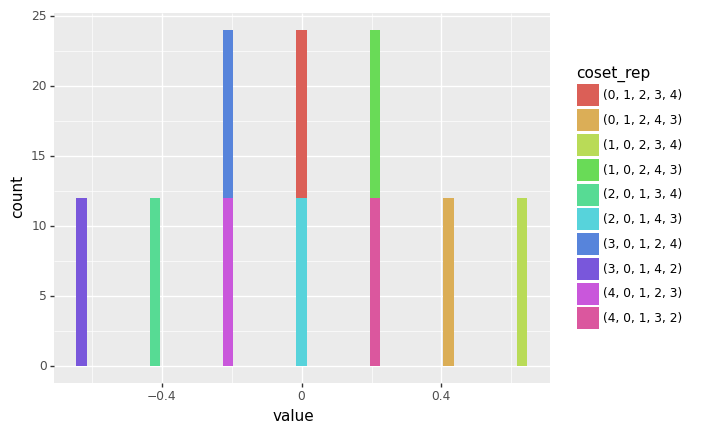

<ggplot: (700779776)>

In [113]:
df = (
    left_base_df
    .filter(pl.col('variable') == 'dim12')
    .join(full_right_coset_df, on='permutation')
    .filter(pl.col('subgroup') == 'A4_0')
)

ggplot(df, aes(x = 'value', fill = 'coset_rep')) + geom_histogram(binwidth=0.03)

In [115]:
df['value'].sum()

0.00015735626220703125

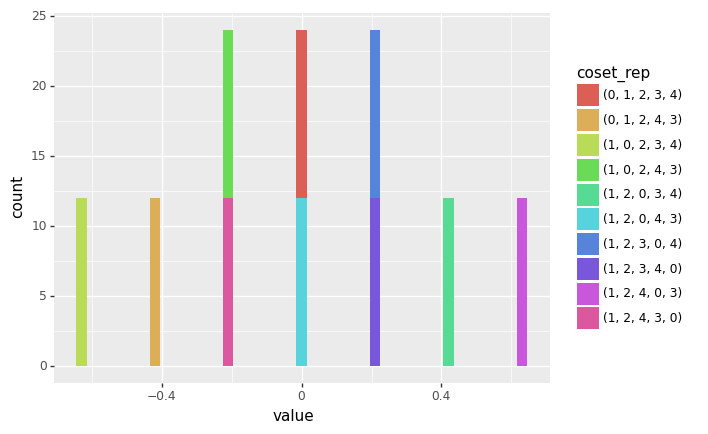

<ggplot: (700704042)>

In [112]:
df = (
    right_base_df
    .filter(pl.col('variable') == 'dim12')
    .join(full_left_coset_df, on='permutation')
    .filter(pl.col('subgroup') == 'A4_0')
)

ggplot(df, aes(x = 'value', fill = 'coset_rep')) + geom_histogram(binwidth=0.03)

In [100]:
from sngrok.cosets import get_left_cosets, get_right_cosets, get_double_cosets, get_double_cosets_two_groups

s3xs2_0 = generate_subgroup(all_s5_subgroups['S2xS3']['generators'][0])
s3xs2_3 = generate_subgroup(all_s5_subgroups['S2xS3']['generators'][3])

s3xs2_6 = generate_subgroup(all_s5_subgroups['S2xS3']['generators'][6])


In [101]:
def basic_coset_df(cosets, sg_name):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'subgroup': sg_name, f'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)


double_cosets = list(get_double_cosets_two_groups(s3xs2_6, s3xs2_3,  5))


double_coset_df = basic_coset_df(double_cosets, 'S3xS2')



In [97]:
double_coset_df.filter(pl.col('coset_rep') == '(2, 0, 3, 4, 1)')

permutation,subgroup,coset_rep
str,str,str
"""(2, 0, 3, 4, 1…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(2, 0, 4, 3, 1…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(2, 1, 3, 4, 0…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(2, 1, 4, 3, 0…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(3, 0, 2, 4, 1…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(3, 0, 4, 2, 1…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(3, 1, 2, 4, 0…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(3, 1, 4, 2, 0…","""S3xS2""","""(2, 0, 3, 4, 1…"
"""(4, 0, 2, 3, 1…","""S3xS2""","""(2, 0, 3, 4, 1…"


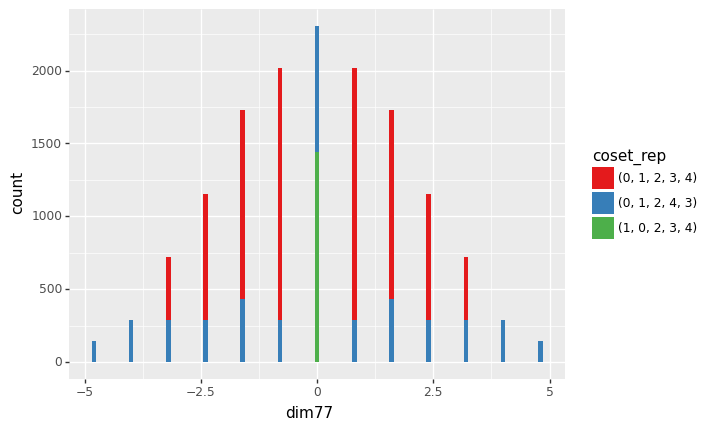

<ggplot: (703705659)>

In [102]:
from plotnine import scale_fill_brewer

df = (
    preacts_df
    #.filter(pl.col('variable') == 'dim90')
    .join(double_coset_df, right_on='permutation', left_on='permutation_target')
)

ggplot(df, aes(x = 'dim77', fill = 'coset_rep')) + geom_histogram(binwidth=0.1) + scale_fill_brewer(type='qual', palette=6)

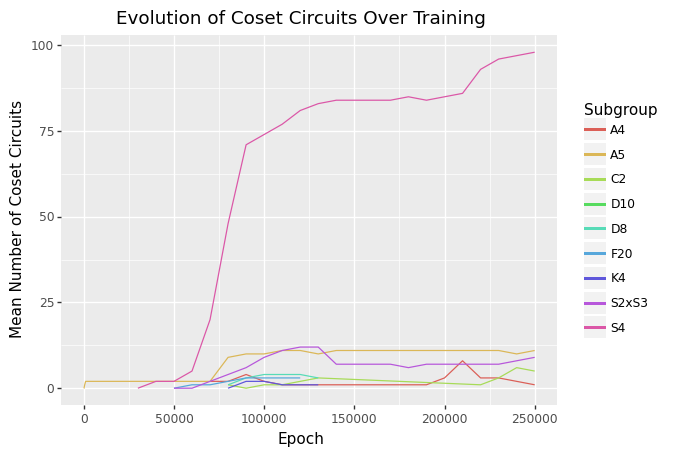

<ggplot: (697387690)>

In [31]:
from plotnine import theme_minimal, labs

df = (
    merged_df
    #.filter(pl.col('subgroup_class') == 's4')
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_two_norm = pl.col('two_norm').mean(),
        min_two_norm = pl.col('two_norm').min(),
        max_two_norm = pl.col('two_norm').max(),
        mean_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('coset_var_ratio').max(),
        full_count = pl.count(),
        count = (pl.col('coset_var_ratio') < 1.0).sum(),
        norm_count = (pl.col('coset_var_ratio') < 1.0).sum() 
    )
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_coset_var_ratio = pl.col('mean_coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('mean_coset_var_ratio').median(),
        coset_var_ratio25 = pl.col('mean_coset_var_ratio').quantile(0.25),
        coset_var_ratio75 = pl.col('mean_coset_var_ratio').quantile(0.75),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('mean_coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('mean_coset_var_ratio').max(),
        full_count = pl.count(),
        count = pl.col('count').mean(),
        norm_count = pl.col('norm_count').mean(),
        norm_count_sd = pl.col('norm_count').std(),
        norm_count50 = pl.col('norm_count').median(),
        norm_count25 = pl.col('norm_count').quantile(0.25),
        norm_count75 = pl.col('norm_count').quantile(0.75)
         
    )
    .filter(pl.col('subgroup_class') != 'mixed')
    .sort(['epoch', 'subgroup_class'])
)
fig = (
    ggplot(
        df,
        aes(
            x = 'epoch',
            y = 'norm_count',
            color = 'subgroup_class',
            fill = 'subgroup_class'
        )
    ) 
    + geom_line() #+ geom_ribbon(alpha=0.25)
    #    + theme(axis_text_x=element_text(angle=15))
    + labs(
        x = 'Epoch',
        y = 'Mean Number of Coset Circuits',
        title = 'Evolution of Coset Circuits Over Training',
        color='Subgroup',
        fill='Subgroup'
    )
)

fig

In [ ]:
irrep_df.head()

In [505]:


def full_power_analysis(tensor, n, layer):
    dims = [f'dim{i}' for i in range(tensor.shape[1])]
    l2_power = (tensor ** 2).mean(dim=0)
    l1_power = tensor.abs().mean(dim=0)
    
    basic_df = pl.DataFrame({
        'dim': dims,
        'l2': l2_power.detach().cpu().numpy(),
        'l1': l1_power.detach().cpu().numpy()
    })
    
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / l2_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    contrib_vals = torch.cat([irrep_power[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    power_df = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=dims)
    power_df.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))

    contrib_df = pl.DataFrame(contrib_vals.detach().cpu().numpy(), schema=dims)
    contrib_df.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    
    df = (
        power_df
        .melt(id_vars='irrep', variable_name='dim', value_name='power_pcnt')
        .join(contrib_df.melt(id_vars='irrep', variable_name='dim', value_name='power_raw'), on=['irrep', 'dim'])
        .sort(['dim', 'power_pcnt'])
        .groupby('dim', maintain_order=True)
        .agg([
            pl.col('power_pcnt').entropy().alias('fourier_entropy'),
            pl.col('irrep').last().alias('max_irrep'),
            pl.col('power_pcnt').max().alias('max_power'),
            pl.col('power_raw').max().alias('max_frob_norm'),
            pl.col('power_raw').mean().alias('mean_frob_norm'),
            pl.col('power_raw').var().alias('var_frob_norm'),
            
        ])
        .join(basic_df, on='dim')
    )
    df.insert_at_idx(0, pl.Series('layer', [layer] * df.shape[0]))
    return df



def _fourier_analysis(model_run):
    #lperms, rperms, targets = perms
    
    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    #logits, cache = model.run_with_cache(lperms, rperms)
    
    #original_loss = loss_fn(logits, targets).mean()
    
    #linear_acts = cache['hook_linear']
    S5 = Symmetric(5)
    
    config = model_run['config']
    embed_dim = config['embed_dim']
    W = model.linear.weight
    
    left_emb_power_df = full_power_analysis(model.lembed.weight, 5, 'left_embed')
    right_emb_power_df = full_power_analysis(model.rembed.weight, 5, 'right_embed')
    
    left_lin_power_df = full_power_analysis(model.lembed.weight @ W[:, :embed_dim].T, 5, 'left_linear')
    right_lin_power_df = full_power_analysis(model.rembed.weight @ W[:, embed_dim:].T, 5, 'right_linear')
    unembed_power_df = full_power_analysis(model.unembed.weight, 5, 'unembed')

    
    power_df = pl.concat(
        [
            left_emb_power_df,
             right_emb_power_df,
             left_lin_power_df,
             right_lin_power_df,
             unembed_power_df
        ],
        how='vertical'
    )
    
    return power_df
    

def fourier_entropy_over_time(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    #print(checkpoint_epochs)
    
    #loss_df = pl.DataFrame({
    #    'epoch': checkpoint_epochs,
    #    'seed': [model_seed] * len(checkpoint_epochs),
    #    'train_loss': full_run['train_loss'],
    #    'test_loss': full_run['test_loss']
    #})
    
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    data = []
    for epoch, ckpt_fp in zip(checkpoint_epochs, checkpoint_paths):
        ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
        df = _fourier_analysis(ckpt)
        df.insert_at_idx(0, pl.Series('epoch', [epoch] * df.shape[0]))
        data.append(df)
    
    all_data = pl.concat(data, how='vertical')

    return all_data
    
    

In [ ]:
from tqdm.notebook import tqdm

merged_data = []
lr_data = []

for i in tqdm(range(128)):
    merged_df, lr_df = cosets_over_time(i)
    merged_data.append(merged_df)
    lr_data.append(lr_df)
    
merged_df = pl.concat(merged_data)
lr_df = pl.concat(lr_data)

In [506]:

all_entropy_data =  []

for i in range(128):
    data = fourier_entropy_over_time(i)
    data.insert_at_idx(0, pl.Series('seed', [i] * data.shape[0]))
    all_entropy_data.append(data)


all_entropy_df = pl.concat(all_entropy_data)
    
    

In [556]:
all_entropy_df.write_parquet('s5_40_small_fourier_entropy.parquet')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_fourier_entropy.pdf


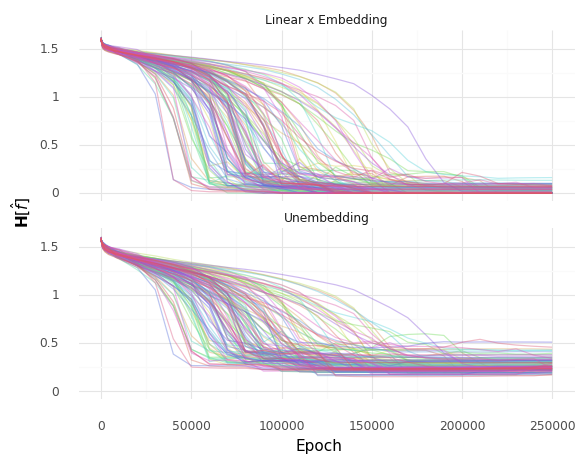

<ggplot: (690658974)>

In [555]:
from plotnine import scale_color_hue

layer_rename = {
    'left_embed': 'Embedding',
    'right_embed': 'Embedding',
    'left_linear': 'Linear x Embedding',
    'right_linear': 'Linear x Embedding',
    'unembed': 'Unembedding'

}


df = (
    all_entropy_df
    
    .filter(pl.col('layer').is_in(['unembed', 'left_linear', 'right_linear']))
    .with_columns([
        pl.col('layer').map_dict(layer_rename),
        pl.col('fourier_entropy').fill_nan(0)
    ])
    .sort(['seed', 'epoch', 'dim']).groupby(['seed', 'epoch', 'layer']).agg([
        pl.col('fourier_entropy').mean(),
        pl.col('l1').mean(),
        pl.col('l2').mean()
    ])
)


fig = (
    ggplot(df, aes(x='epoch', y='fourier_entropy', color='factor(seed)')) 
    + geom_line(alpha=0.4, show_legend=False)
    + labs(x='Epoch', y='$\\mathbf{H}[\\hat{f}]$')
    + theme_minimal()
    + facet_wrap('~layer', nrow=2)
    + scale_color_hue()
   #+ theme(axis_text_x=element_text(angle=45))
)
fig.save('s5_40_fourier_entropy.pdf')
fig

In [593]:
for df in frob_right_coset_df.filter(pl.col('subgroup') == 'frob20_3').partition_by('coset_rep'):
    perms = [Permutation(eval(p)) for p in df['permutation'].to_list()]
    cycle_reps = sorted([p.cycle_rep for p in perms], key=lambda x: (len(x), x))
    print(df['coset_rep'][0],'\t' ,cycle_reps[-1])

(0, 1, 4, 2, 3) 	 [(1, 2), (4,), (3,), (0,)]
(0, 1, 3, 2, 4) 	 [(2, 3), (4,), (1,), (0,)]
(0, 1, 2, 3, 4) 	 [(4,), (3,), (2,), (1,), (0,)]
(0, 1, 3, 4, 2) 	 [(1, 3), (4,), (2,), (0,)]
(0, 1, 2, 4, 3) 	 [(3, 4), (2,), (1,), (0,)]
(0, 1, 4, 3, 2) 	 [(2, 4), (3,), (1,), (0,)]


In [567]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(75)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
full_left_coset_df, full_right_coset_df = make_full_coset_df()

preacts_df = get_linear_layer_decomp(75)

In [575]:
frob20_df = full_right_coset_df.filter(pl.col('subgroup').str.starts_with('frob20'))

In [576]:
#power_df.filter((pl.col('layer') == 'left_linear') & (pl.col('irrep') == '(3, 2)')).sort('value').tail()
# 1, 14, 34, 45, 88 --> top five (3, 2) columns
preacts_df.head()

permutation_left,permutation_right,permutation_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,…,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…",0.119511,-2.97561,3.742235,-1.015843,2.524415,3.774594,2.693851,1.570089,2.785964,5.722211,-0.164407,-1.325086,-2.960897,3.765867,0.005044,-0.100605,3.293517,0.000425,2.76369,1.124169,-0.359039,-0.001247,3.704182,-4.477051,5.582246,-6.763732,-0.577817,3.951877,3.044426,0.147571,0.310781,-1.059696,2.868944,0.921814,…,5.669798,6.711197,-0.356774,0.424862,0.150652,0.132951,-1.346638,0.593281,-0.000071,-0.402789,0.313119,5.461452,4.141118,-3.3419,0.025463,0.171132,-0.957151,5.747149,0.006423,-6.058769,-3.375849,-5.400948,6.188315,3.203767,-0.000209,-2.585838,-0.053638,-0.000355,-2.384315,-1.820982,-5.056078,3.541672,1.016139,0.922882,-4.977614,3.899156,-2.345867
"""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…","""(0, 1, 3, 4, 2…",0.506242,0.016835,6.005738,-0.295803,-0.108443,-0.2252,6.307226,5.273432,2.641764,4.640473,-0.060493,-1.601716,-2.960987,3.662561,3.291971,2.34609,6.762915,0.005444,-0.260828,0.809283,-0.573991,-3.353965,0.03186,-5.591715,5.380972,-0.001271,-3.821877,4.18742,0.008898,-0.659176,-0.017333,-1.255319,0.246948,0.91186,…,-0.433628,6.693514,-0.507131,-5.349803,5.305568,5.825748,-1.348028,-4.251092,-3.216574,-2.709168,-2.400569,5.476645,-0.187336,-3.341334,0.038658,4.214596,-6.407785,1.238988,0.197914,-6.063677,-6.963585,-5.362058,6.238595,3.192331,-0.000536,-0.281735,1.114666,0.437026,-2.38392,-5.597033,-2.356857,-1.927202,-3.319921,0.731928,0.97143,4.098882,0.064993
"""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…","""(0, 1, 4, 2, 3…",-0.240295,3.153558,-0.315263,0.091021,0.038858,1.475099,1.513275,5.042389,0.150184,1.851344,-0.270414,-1.719566,-2.950927,4.019951,-3.097201,-0.34698,0.00924,-0.000034,0.065157,0.982469,-0.51175,-6.909338,4.242336,-5.207682,5.784032,-3.283457,-3.464824,3.997187,-3.220277,0.117572,-2.427352,-1.23403,3.242525,0.912478,…,4.991488,6.547859,-3.37029,0.003426,5.525771,2.654549,-1.346994,-3.806867,3.033476,0.279728,0.490747,5.477691,5.798283,-3.341352,0.000485,5.959618,-3.33546,3.422821,0.026898,-6.063807,-0.000049,-5.749619,6.23871,3.633375,-0.000016,-3.047419,-5.195981,0.138417,-2.38401,1.731927,1.813689,-3.966725,-3.428563,0.688805,-3.737191,4.173054,0.52001
"""(0, 1, 2, 3, 4…","""(0, 2, 1, 4, 3…","""(0, 2, 1, 4, 3…",0.176697,-2.975706,5.979311,-0.440055,-0.01693,2.397718,6.244594,5.778273,0.249893,1.425646,-0.124617,-0.032988,-5.089512,0.161628,1.435877,2.216224,4.792919,-2.375961,0.198391,0.603525,-0.14389,-0.000722,3.888497,-5.293182,4.842611,1.85473,-3.134103,4.317619,3.044026,-0.439879,-2.648301,-1.060056,0.274594,0.136239,…,5.124897,6.59005,-3.617895,-0.061626,5.77706,3.643121,-1.347254,-4.607392,-1.403081,-4.215676,-2.26555,3.629194,0.72887,2.007149,0.000253,1.546726,-2.799278,-0.002045,0.02752,2.369838,-4.940733,-5.593935,6.825337,-0.261125,2.481077,-0.275479,1.212659,0.130055,-1.720762,-3.468724,-4.770733,-1.927571,-0.398711,0.840243,-4.755032,4.025955,-0.626255
"""(0, 1, 2, 3, 4…","""(0, 2, 3, 1, 4…","""(0, 2, 3, 1, 4…",0.029477,3.153829,4.268626,2.195254,0.063364,0.965195,3.601031,1.707769,0.442012,4.631691,-0.127018,3.836735,0.00093,0.106324,-1.591088,2.659433,1.595294,3.406583,0.229398,-0.274501,0.104863,-6.911499,-0.173545,-5.053066,5.177115,-4.801

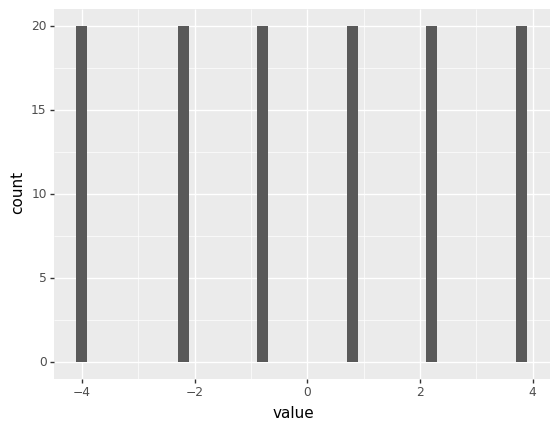

<ggplot: (690406064)>

In [596]:
frob3_coset_rename = {
    '(0, 1, 4, 2, 3)': '$F_{20}(2\;3)$',
    '(0, 1, 3, 2, 4)': '$F_{20}(3\;4)$',
    '(0, 1, 2, 3, 4)': '$F_{20}$',
    '(0, 1, 3, 4, 2)': '$F_{20}(2\;4)$',
    '(0, 1, 2, 4, 3)': '$F_{20}(4\;5)$',
    '(0, 1, 4, 3, 2)': '$F_{20}(3\;5)$'
}

df = (
    left_base_df
    .filter(pl.col('variable') == 'dim1')
    .select(['permutation', 'value'])
    .join(frob20_df.filter(pl.col('subgroup') == 'frob20_3'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(frob3_coset_rename))
)
ggplot(df, aes(x = 'value')) + geom_histogram(binwidth=0.2)

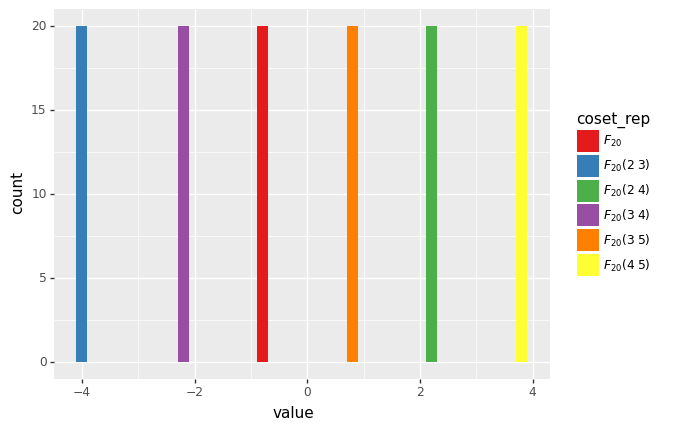

<ggplot: (692066773)>

In [598]:

(
    ggplot(
        df.with_columns(),
        aes(x = 'value', fill='coset_rep')
    )
    + geom_histogram(binwidth=0.2)
    + scale_fill_brewer(type='qual', palette=6)
)

In [433]:
W = model.linear.weight
left_lin_power_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
right_lin_power_df, _ = calc_power_contributions(model.rembed.weight @ W[:, 256:].T, 5)

In [459]:
def full_power_analysis(tensor, n):
    dims = [f'dim{i}' for i in range(tensor.shape[1])]
    l2_power = (tensor ** 2).mean(dim=0)
    l1_power = tensor.abs().mean(dim=0)
    
    basic_df = pl.DataFrame({
        'dim': dims,
        'l2': l2_power.detach().cpu().numpy(),
        'l1': l1_power.detach().cpu().numpy()
    })
    
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / l2_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    contrib_vals = torch.cat([irrep_power[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    power_df = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=dims)
    power_df.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))

    contrib_df = pl.DataFrame(contrib_vals.detach().cpu().numpy(), schema=dims)
    contrib_df.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    
    df = (
        power_df
        .melt(id_vars='irrep', variable_name='dim', value_name='power_pcnt')
        .join(contrib_df.melt(id_vars='irrep', variable_name='dim', value_name='power_raw'), on=['irrep', 'dim'])
        .sort(['dim', 'power_pcnt'])
        .groupby('dim', maintain_order=True)
        .agg([
            pl.col('power_pcnt').entropy().alias('fourier_entropy'),
            pl.col('irrep').last().alias('max_irrep'),
            pl.col('power_pcnt').max().alias('max_power'),
            pl.col('power_raw').max().alias('max_frob_norm'),
            pl.col('power_raw').mean().alias('mean_frob_norm'),
            pl.col('power_raw').var().alias('var_frob_norm'),
            
        ])
        .join(basic_df, on='dim')
    )
    return df
    

In [462]:
df = full_power_analysis(model.rembed.weight, 5)
df.head()

dim,fourier_entropy,max_irrep,max_power,max_frob_norm,mean_frob_norm,var_frob_norm,l2,l1
str,f32,str,f32,f32,f32,f32,f32,f32
"""dim0""",0.320243,"""(2, 1, 1, 1)""",0.914778,0.027297,0.004263,0.000104,0.02984,0.145081
"""dim1""",0.354896,"""(2, 1, 1, 1)""",0.902448,0.026534,0.0042,0.000098,0.029402,0.145281
"""dim2""",0.364061,"""(2, 1, 1, 1)""",0.899109,0.02687,0.004269,0.0001,0.029885,0.146878
"""dim3""",0.377106,"""(2, 1, 1, 1)""",0.893854,0.026637,0.004257,0.000099,0.029801,0.146716
"""dim4""",0.364145,"""(2, 1, 1, 1)""",0.899474,0.026223,0.004165,0.000096,0.029154,0.145332


In [27]:
#merged_df, lr_df = cosets_over_time(5)

merged_df = pl.read_parquet('s5_small_coset_stats.parquet')
lr_df = pl.read_parquet('s5_small_left_right_cosets.parquet')

In [49]:
(
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    .filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
    .select('variable')
)

variable
str
"""dim23"""
"""dim51"""
"""dim126"""
"""dim42"""


In [31]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(5)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
full_left_coset_df, full_right_coset_df = make_full_coset_df()

In [93]:
subgroup_counts = (
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    #.filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
    .groupby('subgroup_pair').count()
    .sort('count')
)

unembed_cols = (
    merged_df
    
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    #.filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
    .join(subgroup_counts, on='subgroup_pair')
    .sort(['count', 'subgroup_pair', 'variable'])
    .select('variable')
)['variable'].to_list()

In [107]:
unembed_base = (
    unembed_df
    .select(pl.exclude('irrep'))
    .groupby(['layer', 'permutation']).sum()
)
unembed_base.head()

layer,permutation,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,…,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""unembed""","""(0, 3, 2, 4, 1…",0.210007,0.203454,0.000036,0.000056,0.177459,0.112357,0.213859,0.11232,0.182319,0.287877,0.265201,0.000027,0.268605,0.171967,0.320614,0.206167,-0.382612,0.000016,0.200945,0.331004,0.174293,-0.609445,0.069322,-0.551004,0.226464,0.245617,0.000008,0.150084,0.210255,0.465373,0.285183,0.171178,0.156835,0.273798,0.239001,…,0.160424,0.475346,0.270734,-0.572601,0.150135,0.23315,0.11228,0.226101,0.259908,0.00001,0.156266,-0.605919,0.122475,0.000036,0.297817,0.000008,-0.460503,-0.382358,-0.586239,0.167215,-0.461483,0.000039,0.301675,0.269003,0.182418,-0.012808,0.000011,-0.585744,0.176339,0.000046,0.112207,0.302846,0.171165,-0.01613,0.000369,-0.528587,-0.578808
"""unembed""","""(2, 0, 1, 3, 4…",-0.558571,-0.501368,-0.000523,-0.000802,0.1968,0.111027,-0.536313,0.111157,0.217087,-0.576269,0.310134,-0.00039,-0.532538,0.190654,0.226678,0.27003,-0.380416,-0.000043,0.196627,-0.596395,0.266861,0.307853,0.09426,0.251303,0.237922,0.251998,-0.000115,0.168263,0.248196,0.463523,0.290196,-0.482284,-0.493025,0.279109,-0.521973,…,0.236361,0.498614,0.236712,0.238053,0.200297,-0.532208,0.111151,0.228344,0.313082,-0.000148,0.135361,0.283456,0.218574,-0.000513,-0.562444,-0.000115,0.202376,-0.380164,0.263436,-0.472335,0.169806,-0.000558,0.241887,0.266768,-0.544948,0.004122,-0.000151,0.275102,-0.480414,-0.000655,0.111115,0.176887,-0.482273,0.005025,0.001071,0.198372,0.244745
"""unembed""","""(2, 0, 3, 4, 1…",0.293209,0.196311,-0.000572,-0.000878,0.156793,0.125971,0.224474,0.126095,-0.580504,-0.58344,0.283858,-0.000427,0.250943,0.208534,0.182584,0.253496,-0.385006,-0.000047,0.195007,-0.599344,0.258759,0.311091,0.097348,0.285766,0.238304,0.20381,-0.000126,0.214325,0.27894,0.481416,0.206318,-0.496579,-0.504268,0.262196,0.207798,…,0.198725,0.479389,0.268217,-0.603364,0.22483,0.22604,0.126082,0.231223,0.268026,-0.000162,0.151996,-0.609976,0.183328,-0.000562,0.273944,-0.000126,-0.457042,-0.38475,-0.562666,-0.485158,0.149186,-0.000611,0.275115,0.267645,0.255617,-0.012873,-0.000166,0.263555,0.153001,-0.000717,0.12604,0.292703,-0.49657,-0.015686,0.000804,0.208657,0.263234
"""unembed""","""(2, 0, 4, 1, 3…",0.295855,0.201817,-0.000608,-0.000933,0.204664,0.126408,0.244304,0.126405,0.311838,-0.564969,0.319956,-0.000454,0.231548,0.220537,0.229472,0.202414,-0.395699,-0.000046,0.190203,-0.591146,0.246643,0.296532,0.076579,0.246894,0.184728,-0.525744,-0.000134,0.202266,-0.539114,0.498388,0.267649,-0.501329,-0.503951,0.237095,0.264831,…,-0.479125,0.456235,0.2646,0.29547,-0.520352,0.189943,0.126368,0.227295,0.253102,-0.000172,0.153081,0.265239,0.140539,-0.000597,0.270279,-0.000134,0.188504,-0.39544,0.258455,-0.471749,0.20733,-0.000649,0.305182,0.259144,0.254024,0.003409,-0.000176,0.266749,0.192368,-0.000762,0.126296,-0.552705,-0.501318,0.003947,0.00027,0.235335,0.276546
"""unembed""","""(2, 1, 4, 3, 0…",-0.585003,0.139606,-0.000599,-0.000919,0.19837,0.129853,0.235881,0.129942,0.257323,-0.569678,0.284,-0.000447,-0.555523,0.220362,-0.55613,0.232814,-0.388472,-0.000049,0.083837,0.248421,-0.578423,0.259663,0.09748,0.291147,0.224724,0.24921,-0.000132,0.213464,0.26971,0.487614,0.244783,0.245023,-0.500271,0.260242,-0.530059,…,0.175892,0.453158,-0.558801,0.258376,-0.506093,0.232899,0.129923,0.29204

In [113]:
from plotnine import geom_tile
corrs = unembed_base.select(unembed_cols).corr()
corrs.insert_at_idx(0, pl.Series('left_cols', unembed_cols))
corr_df = corrs.melt(id_vars='left_cols', variable_name='right_cols')



In [62]:
merged_df.head()

seed,epoch,layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
i64,i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
0,0,"""left_linear""","""dim5""","""a5_0""",0.325513,0.01931,-0.91423,1.275069,0.161517,19.265306,2.015344,"""a5""","""right_linear""","""a5_0""",0.363176,-0.04661,-1.078822,0.967914,0.181016,21.801584,2.006324,"""a5""","""(a5_0, a5_0)""",0.344345,2.010834,20.533445,"""a5"""
0,0,"""left_linear""","""dim14""","""a5_0""",0.356455,-0.029171,-0.981152,0.830798,0.176811,21.142574,2.016027,"""a5""","""right_linear""","""a5_0""",0.274251,-0.001815,-0.779906,0.939263,0.136014,16.186052,2.016345,"""a5""","""(a5_0, a5_0)""",0.315353,2.016186,18.664314,"""a5"""
0,0,"""left_linear""","""dim24""","""a5_0""",0.304858,-0.066634,-0.886384,0.844595,0.151148,18.519444,2.016949,"""a5""","""right_linear""","""a5_0""",0.367453,-0.011444,-1.369133,1.107524,0.193276,23.015509,1.901186,"""a5""","""(a5_0, a5_0)""",0.336156,1.959068,20.767475,"""a5"""
0,0,"""left_linear""","""dim25""","""a5_0""",0.331862,-0.040986,-1.113429,0.984294,0.164617,19.791054,2.015957,"""a5""","""right_linear""","""a5_0""",0.297718,0.01681,-0.979609,1.009379,0.162748,19.4009,1.82932,"""a5""","""(a5_0, a5_0)""",0.31479,1.922639,19.595978,"""a5"""
0,0,"""left_linear""","""dim26""","""a5_0""",0.368412,-0.026045,-0.973703,0.804987,0.184445,22.030352,1.997407,"""a5""","""right_linear""","""a5_0""",0.351523,-0.04382,-1.091406,1.050281,0.174348,20.977892,2.016212,"""a5""","""(a5_0, a5_0)""",0.359967,2.006809,21.504122,"""a5"""


In [59]:
(
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    #.filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
    .groupby('subgroup_pair').count()
    .sort('count')
)
cols02 = (
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    #.filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
    .filter(pl.col('subgroup_pair') == "(s4_0, s4_2)")
    .sort('variable')
)['variable'].to_list()

In [118]:
from plotnine import geom_tile
coset_pairs = (
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    .filter(pl.col('seed') == 5)
    .select(['variable', 'subgroup_pair'])
)
corrs = unembed_base.select(unembed_cols).corr()
corrs.insert_at_idx(0, pl.Series('left_cols', unembed_cols))
corr_df = corrs.melt(id_vars='left_cols', variable_name='right_cols')
corr_df = corr_df.join(coset_pairs, left_on='left_cols', right_on='variable').rename({'subgroup_pair': 'left_coset'})
corr_df = corr_df.join(coset_pairs, left_on='right_cols', right_on='variable').rename({'subgroup_pair': 'right_coset'})

#ggplot(corr_df, aes(x='left_cols', y='right_cols', fill='value')) + geom_tile()

In [119]:
corr_df.filter(pl.col('left_coset') == pl.col('right_coset')).sort('value').head(20)

left_cols,right_cols,value,left_coset,right_coset
str,str,f64,str,str
"""dim92""","""dim59""",-0.999465,"""(a5_0, a5_0)""","""(a5_0, a5_0)"""
"""dim59""","""dim92""",-0.999465,"""(a5_0, a5_0)""","""(a5_0, a5_0)"""
"""dim59""","""dim29""",-0.999444,"""(a5_0, a5_0)""","""(a5_0, a5_0)"""
"""dim29""","""dim59""",-0.999444,"""(a5_0, a5_0)""","""(a5_0, a5_0)"""
"""dim29""","""dim16""",-0.999396,"""(a5_0, a5_0)""","""(a5_0, a5_0)"""


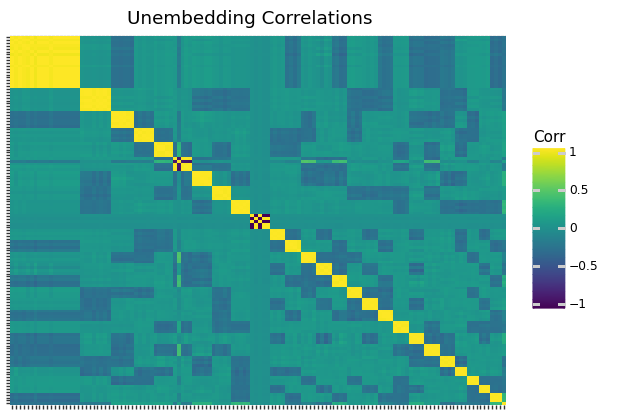

<ggplot: (734964403)>

In [120]:
from plotnine import scale_fill_continuous, scale_x_discrete, scale_y_discrete, coord_trans, scale_fill_brewer, labs

#df = corr_df.groupby(['left_coset', 'right_coset']).agg(pl.col('value').mean())

fig = (
    ggplot(corr_df, aes(x='left_cols', y='right_cols', fill='value')) 
    + geom_tile() 
    + scale_x_discrete(limits=unembed_cols[::-1], labels=[])
    + scale_y_discrete(limits=unembed_cols, labels=[])
    + scale_fill_continuous(limits=[-1, 1])
    + labs(title='Unembedding Correlations', fill='Corr', x='', y='')
)
fig.save('unembed_corr_seed5.pdf')
fig

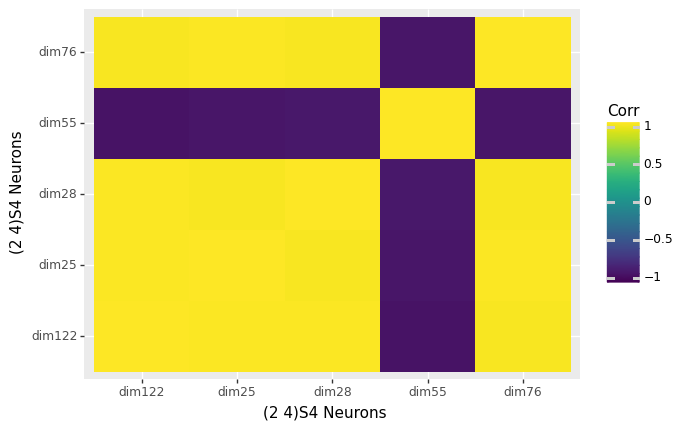

<ggplot: (705380217)>

In [421]:
df = corr_df.filter((pl.col('left_coset') == "(s4_3, s4_1)") & (pl.col('right_coset') == "(s4_3, s4_1)"))

(
    ggplot(df, aes(x='left_cols', y='right_cols', fill='value')) 
    + geom_tile() 
    #+ scale_x_discrete(limits=unembed_cols[::-1], labels=[])
    #+ scale_y_discrete(limits=unembed_cols, labels=[])
    + scale_fill_continuous(limits=[-1, 1])
    + labs(fill='Corr', x='(2 4)S4 Neurons', y='(2 4)S4 Neurons')
)

In [135]:
cols = (
    corr_df
    .filter(pl.col('left_coset') == "(s4_0, s4_0)")['left_cols']
    .str.strip('dim')
    .str.parse_int(10)
    .unique().sort()
).to_list()

[23, 42, 51, 126]

In [ ]:
def get_linear_layer_decomp(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    model = SnMLP.from_config(full_run['config'])
    model.load_state_dict(full_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(logits, targets)

    linear_acts = cache['hook_linear']
    df = pl.concat(
        [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(linear_acts.shape[1])])],
        how='horizontal'
    )
    return df.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
    

In [137]:
model_seed = 5
ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
run_name = f's5_40_{model_seed}'

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

#full_left_coset_df, full_right_coset_df = make_full_coset_df()

checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)

model = SnMLP.from_config(full_run['config'])
model.load_state_dict(full_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(logits, targets)

linear_acts = cache['hook_linear']

In [161]:
def get_s4_coset(col_name, element):
    new_val = {
        0: 'S4',
        1: '(1 2)S4',
        2: '(1 3)S4',
        3: '(1 4)S4',
        4: '(1 5)S4',
        
    }
    return (
        pl.col(col_name)
        .str.extract_all('([0-4])')
        .list.eval((pl.element() == element).cast(pl.UInt32))
        .list.arg_max().map_dict(new_val)
    )

In [181]:
acts_df = get_linear_layer_decomp(5)

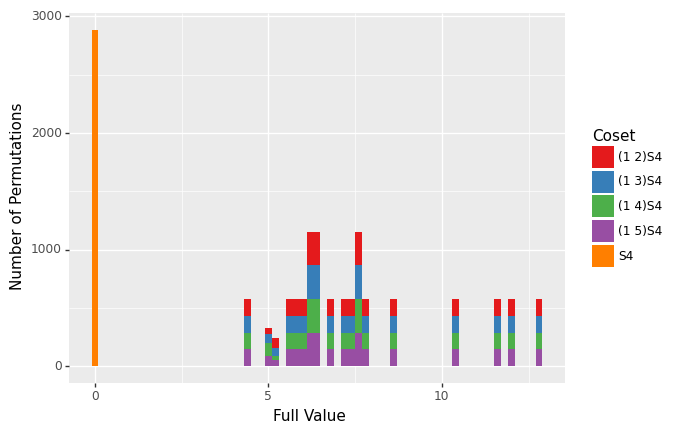

<ggplot: (725228058)>

In [194]:

left_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(1, 0, 2, 3, 4)': '(1 2)S4',
    '(1, 2, 0, 3, 4)': '(1 3)S4',
    '(1, 2, 3, 0, 4)': '(1 4)S4',
    '(1, 2, 3, 4, 0)': '(1 5)S4',

}

dflin = (
    linear_df
    .select(['permutation_left', 'permutation_right', 'permutation_target', 'dim23', 'dim42', 'dim51', 'dim126'])
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'])
    .join(s4_left_coset_df.filter(pl.col('subgroup') == 's4_0'), left_on='permutation_target', right_on='permutation')
    .with_columns(
        #pl.Series('layer', ['Left + Right Permutations']* 14400),
        pl.col('coset_rep').map_dict(left_coset_rename),
        pl.col('value').clip_min(0).alias('relu_value')
    )
    .groupby(['permutation_left', 'permutation_right', 'permutation_target', 'coset_rep'])
    .agg(pl.col('relu_value').sum().alias('value'))
)


fig = (
    ggplot(dflin, aes(x='value', fill = 'coset_rep')) 
    + geom_histogram(binwidth=0.2)
    #+ facet_wrap('~variable')
    + labs(y = "Number of Permutations", x = "Full Value", fill="Coset")
    + scale_fill_brewer(type='qual', palette=6)
)
fig



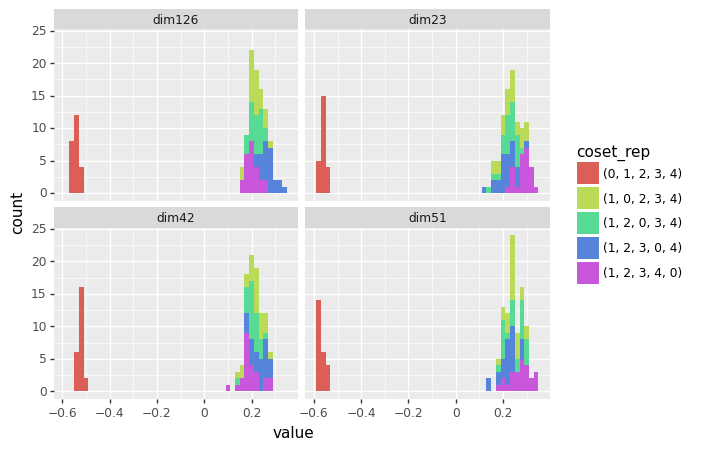

<ggplot: (728238044)>

In [214]:

df = (
    unembed_base
    .select(['permutation', 'dim23', 'dim42', 'dim51', 'dim126'])
    .join(s4_left_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .select(pl.exclude('subgroup'))
    .melt(id_vars=['permutation', 'coset_rep'])
)
(
    ggplot(
        df,
        aes(x='value', fill='coset_rep')
    )
    + facet_wrap('~variable')
    + geom_histogram(binwidth=0.02)
    
)


In [230]:
#(model.unembed.weight[:, cols[0]].unsqueeze(1) @ relu(linear_acts[:, cols[0]].T).unsqueeze(0)).shape
cols[0]

23

In [240]:

logits1 = (model.unembed.weight[:, cols[0]].unsqueeze(1) @ relu(linear_acts[:, cols[0]].T).unsqueeze(0)).T.detach().numpy()
logits2 = (model.unembed.weight[:, cols[0:2]] @ relu(linear_acts[:, cols[0:2]].T)).T.detach().numpy()
logits4= (model.unembed.weight[:, cols] @ relu(linear_acts[:, cols].T)).T.detach().numpy()
sn_df = run_data.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
full_group = Permutation.full_group(5)
logit1_df = pl.concat(
    [sn_df, pl.DataFrame(logits1, schema=[str(p) for p in full_group])],
    how='horizontal'
)
logit2_df = pl.concat(
    [sn_df, pl.DataFrame(logits2, schema=[str(p) for p in full_group])],
    how='horizontal'
)
logit4_df = pl.concat(
    [sn_df, pl.DataFrame(logits4, schema=[str(p) for p in full_group])],
    how='horizontal'
)

In [426]:
x = torch.full((7,), 1.0 / 7)
(-1.0 * x * torch.log(x)).sum()

tensor(2.8074)

In [428]:
x = torch.tensor([0.99, 0.005, 0.005, 0, 0, 0., 0 ])
(-1.0 * x * torch.log(x))

tensor([0.0099, 0.0265, 0.0265,    nan,    nan,    nan,    nan])

In [333]:
#logit_df.melt(id_vars = ['permutation_left', 'permutation_right', 'permutation_target'], variable_name = 'permutation_logit')
df1 = (
    logit1_df
    .with_columns(get_s4_coset('permutation_target', '0').alias('coset_target'))
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_target'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .with_columns([
        get_s4_coset('permutation_logit', '0').alias('coset_logit')
    ])
    .filter(pl.col('coset_target') != 'S4')
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])
    
)

df1.insert_at_idx(0, pl.Series('neurons', ['1 S4 Neuron'] * df1.shape[0]))

df2 = (
    logit2_df
    .with_columns(get_s4_coset('permutation_target', '0').alias('coset_target'))
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_target'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .with_columns([
        get_s4_coset('permutation_logit', '0').alias('coset_logit'),
        pl.Series('neurons', ['One S4 Neuron'])
    ])
    .filter(pl.col('coset_target') != 'S4')
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])
    
)
df2.insert_at_idx(0, pl.Series('neurons', ['2 S4 Neurons'] * df2.shape[0]))
                  
df4 = (
    logit4_df
    .with_columns(get_s4_coset('permutation_target', '0').alias('coset_target'))
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_target'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .with_columns([
        get_s4_coset('permutation_logit', '0').alias('coset_logit')
        
    ])
    .filter(pl.col('coset_target') != 'S4')
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])  
)  
df4.insert_at_idx(0, pl.Series('neurons', ['4 S4 Neurons'] * df4.shape[0]))

df = pl.concat([df1, df2, df4])

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: logit_constructive_interference_boxplot.pdf


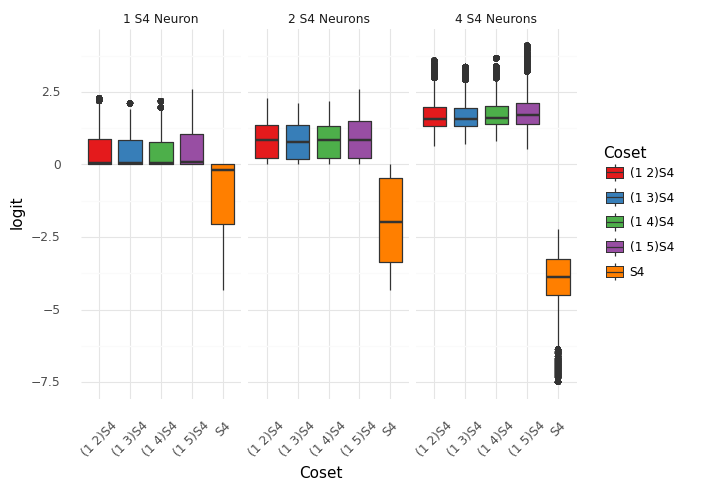

<ggplot: (734785479)>

In [353]:
from plotnine import scale_y_log10, theme_minimal, geom_violin, geom_density, scale_color_brewer
fig = (
    ggplot(df, aes(x='coset_logit', y='logit', fill='coset_logit')) 
    + geom_boxplot()
    + facet_wrap('~neurons')
    + theme_minimal()
    + scale_fill_brewer(type='qual', palette=6)
    + theme(axis_text_x=element_text(angle=45))
    + labs(x = 'Coset', fill='Coset')
)
fig.save('logit_constructive_interference_boxplot.pdf')
fig

In [388]:
corr_df.filter((pl.col('left_coset') == pl.col('right_coset')) & (pl.col('left_coset') == "(s4_3, s4_1)")).sort('value')
# 55


#llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(5)
#left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
#right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
#full_left_coset_df, full_right_coset_df = make_full_coset_df()

left_cols,right_cols,value,left_coset,right_coset
str,str,f64,str,str
"""dim55""","""dim122""",-0.902586,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim122""","""dim55""",-0.902586,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim25""","""dim55""",-0.890339,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim55""","""dim25""",-0.890339,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim76""","""dim55""",-0.884762,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim55""","""dim76""",-0.884762,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim55""","""dim28""",-0.872866,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim28""","""dim55""",-0.872866,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""
"""dim28""","""dim25""",0.98177,"""(s4_3, s4_1)""","""(s4_3, s4_1)"""


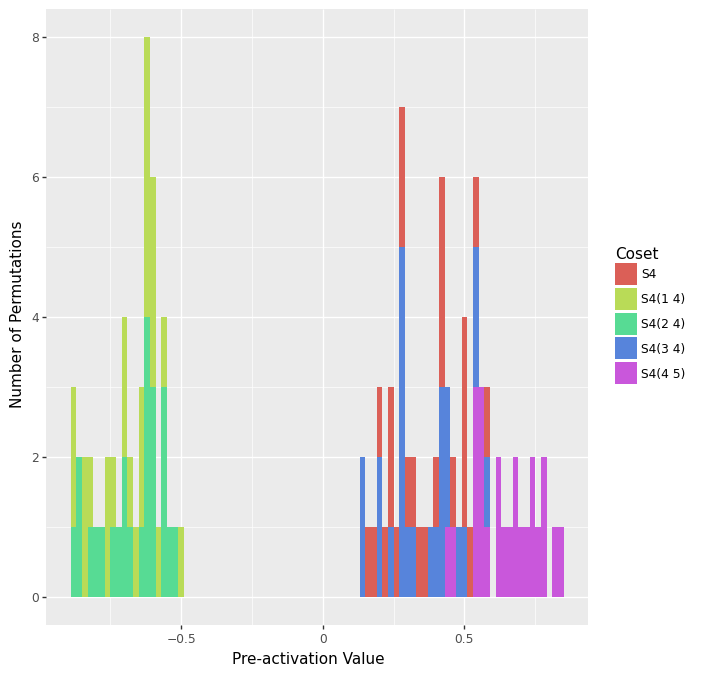

<ggplot: (692229934)>

In [414]:
s4_1_left_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(0, 2, 1, 3, 4)': '(2 3)S4',
    '(0, 2, 3, 1, 4)': '(2 4)S4',
    '(0, 2, 3, 4, 1)': '(2 5)S4',
    '(1, 0, 2, 3, 4)': '(1 2)S4',

}


######################
#######################
s4_3_right_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(0, 1, 2, 4, 3)': 'S4(4 5)',
    '(0, 1, 3, 2, 4)': 'S4(3 4)',
    '(0, 2, 3, 1, 4)': 'S4(2 4)',
    '(1, 2, 3, 0, 4)': 'S4(1 4)'

}

col = 'dim55'


dfl = (
    left_base_df
    .filter(pl.col('variable') == col)
    .join(full_right_coset_df.filter(pl.col('subgroup') == 's4_3'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(s4_3_right_coset_rename))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == col)
    .join(full_left_coset_df.filter(pl.col('subgroup') == 's4_1'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(s4_1_left_coset_rename))
    
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')

#palette = brewer_pal('qual', 6)(5)

#colors = palette + palette[:-1]


(
    ggplot(dfl, aes(x='value', fill='coset_rep')) 
    + geom_histogram(binwidth=0.02) 
   # + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Coset")
    #+ theme_minimal()
    + theme(figure_size=(7,8))
    #+ scale_fill_manual(values = colors)
)



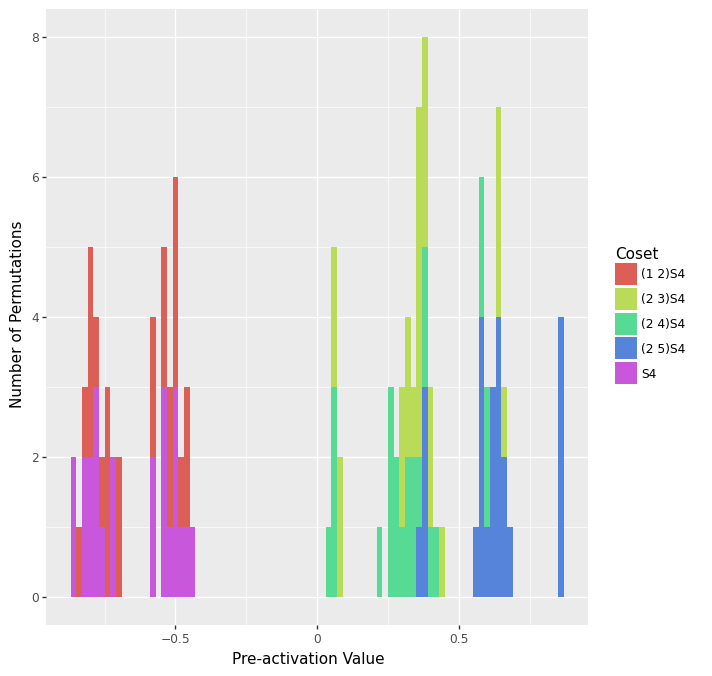

<ggplot: (705737074)>

In [415]:
(
    ggplot(dfr, aes(x='value', fill='coset_rep')) 
    + geom_histogram(binwidth=0.02) 
   # + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Coset")
    #+ theme_minimal()
    + theme(figure_size=(7,8))
    #+ scale_fill_manual(values = colors)
)

In [372]:
linear_df = get_linear_layer_decomp(5)

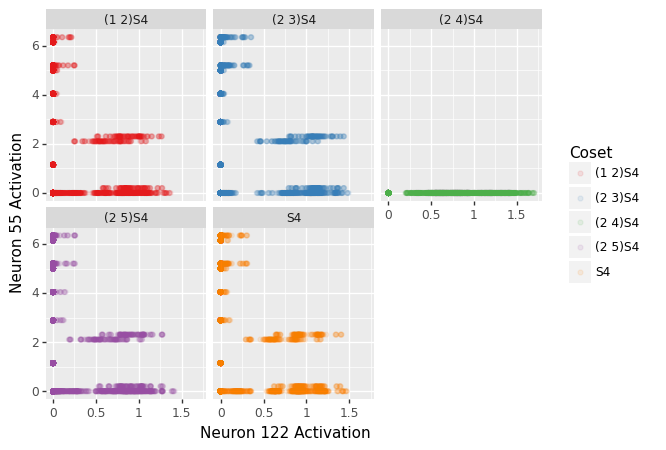

<ggplot: (705096816)>

In [419]:
dflin = (
    linear_df
    .select(['permutation_target', 'dim55', 'dim122'])
    .join(full_left_coset_df.filter(pl.col('subgroup') == 's4_1'), left_on='permutation_target', right_on='permutation')
    .with_columns([
        #if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'),
        pl.Series('layer', ['Left + Right Permutations']* 14400),
        pl.col(col).clip_min(0).alias('relu_55'),
        pl.col('dim122').clip_min(0).alias('relu_122'),
        pl.col('coset_rep').map_dict(s4_1_left_coset_rename)
        
    ])
)

"""

(
    ggplot(dflin, aes(x=col, fill= 'coset_rep')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~coset_rep')
    + labs(x = "Neuron 55 Full Activation", color="Coset")
    + scale_fill_brewer(type='qual', palette=6)
)
"""

(
    ggplot(dflin, aes(x='relu_55', y='relu_122', color= 'coset_rep')) 
    + geom_point(alpha=0.1)
    + facet_wrap('~coset_rep')
    + labs(y = "Neuron 55 Activation", x = "Neuron 122 Activation", color="Coset")
    + scale_color_brewer(type='qual', palette=6)
)


In [123]:
linear_df.head()

permutation_left,permutation_right,permutation_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,…,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…",-0.000489,-0.539649,-0.001795,-0.002754,5.90637,1.283336,-7.420245,1.28284,-2.168574,3.302561,7.245562,-0.00134,-0.000594,-1.742538,0.001005,-1.087948,-0.000167,-0.000324,3.695731,-2.893084,0.001255,-0.000064,-2.36886,0.000071,-1.320013,-1.825406,-0.000396,4.279286,1.901061,6.950511,-7.021312,-1.977151,-1.786743,-0.804646,…,-3.123079,-6.959155,4.750682,-2.155085,-3.686918,0.000228,1.281622,-3.741462,-4.081492,-0.000508,-1.727025,-4.743461,4.3444,-0.001761,0.000532,-0.000395,2.624598,-0.000154,-2.013918,3.359419,0.000504,-0.001915,-6.834663,-3.195221,-0.00031,-0.100654,-0.000519,0.000362,-0.000255,-0.002249,1.28157,-4.999489,-1.975949,-0.131814,-0.006562,0.000034,-5.590658
"""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…","""(0, 1, 3, 4, 2…",-4.309395,-0.539212,-0.004782,-0.007336,5.906631,1.283268,-7.42051,1.282579,0.000958,6.74042,8.417307,-0.003569,8.102036,-1.74258,0.000209,-1.087711,0.000043,-0.00035,3.696476,-2.893718,-0.000268,4.409355,-3.181172,0.00004,-5.160472,-1.825498,-0.001054,-1.984054,1.901721,6.949913,-3.264189,-1.977408,1.5129,-4.311585,…,3.033156,-6.959339,4.750107,-0.000677,-7.013471,3.99647,1.281657,-3.74181,-0.808455,-0.001352,-1.727372,-4.743602,4.34463,-0.004692,-0.801114,-0.001053,0.000405,0.000121,-2.014176,3.359446,0.732563,-0.005101,-6.835046,1.052316,-3.958152,-0.100667,-0.001383,-3.76749,-6.887998,-0.005993,1.281618,-4.999973,-1.976117,-0.131834,-0.000006,0.000261,-0.937759
"""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…","""(0, 1, 4, 2, 3…",-0.987351,-0.539151,-0.006271,-0.00962,5.906492,1.283554,-7.420358,1.283022,0.328352,7.826904,3.546919,-0.004681,4.227227,-1.742276,-0.000154,-1.0877,-0.000069,-0.000206,3.695902,-2.893785,-0.000315,9.196448,-0.832475,0.00027,2.119667,-1.825491,-0.001383,0.929843,1.901486,6.949838,-8.157614,-1.977448,5.071443,-5.455378,…,0.000127,-6.959091,4.75023,-6.264386,-0.000426,-3.429234,1.281938,-3.741503,0.000396,-0.001773,-1.727293,-4.74367,4.344698,-0.006153,3.188675,-0.001381,3.498331,-0.000062,-2.014031,3.359443,-0.737081,-0.006689,-6.834835,-5.196362,1.728506,-0.100665,-0.001814,-5.393472,-3.586122,-0.007858,1.281829,-4.999687,-1.976155,-0.131831,-0.021244,0.000272,-4.483952
"""(0, 1, 2, 3, 4…","""(0, 2, 1, 4, 3…","""(0, 2, 1, 4, 3…",-0.987546,0.000039,-0.002391,-0.003667,5.906145,1.283292,-0.000033,1.282624,0.328364,2.428247,8.417832,-0.001784,4.227343,-2.521862,-1.09443,-1.088009,-0.000276,0.00006,3.695696,-2.893418,7.823425,7.318629,-3.181265,0.000367,-5.160663,-7.675364,-0.000527,0.929733,8.146813,6.950042,-3.263802,-1.977219,3.62981,-0.001015,…,-0.000066,-6.959035,4.750312,-0.000452,-7.013755,3.996268,1.28173,-3.741222,-5.474516,-0.000676,-1.726754,-3.821143,4.344063,-0.002346,-0.801928,-0.000526,0.000313,-0.000207,4.067613,3.359708,-4.409153,-0.00255,-6.834592,1.05245,-3.958579,-0.028871,-0.000691,-0.121635,-3.586561,-0.002996,1.281657,-2.105199,-1.975812,-0.014172,-0.066179,0.000014,-4.483966
"""(0, 1, 2, 3, 4…","""(0, 2, 3, 1, 4…","""(0, 2, 3, 1, 4…",-4.308247,3.886678,-0.00239,-0.003666,5.905831,1.283368,-5.698981,1.282744,0.000583,2.428333,7.245276,-0.001784,8.1019,-5.76694,-5.480094,-1.08805,-0.000187,0.00006,3.695816,-2.893234,2.38

In [ ]:
def if_then(pred, x0, x1):
    return pl.when(pred).then(pl.lit(x0)).otherwise(pl.lit(x1))

In [ ]:
linear_df = get_linear_layer_decomp(5)

In [ ]:
from plotnine import labs, theme_minimal, theme_linedraw, geom_dotplot
dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), on='permutation')
    .with_columns(if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')


fig = (
    ggplot(df, aes(x='value', fill='sign')) 
    + geom_histogram(binwidth=0.1) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Sign")
    + theme_minimal()
    + theme(figure_size=(7,8))
)
fig


In [46]:
fig.save('s5_40_seed5_dim16_sign_plot.png')


/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 7 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim16_sign_plot.png


In [78]:
dflin = (
    linear_df
    .select(['permutation_target', 'dim16'])
    .join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), left_on='permutation_target', right_on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'),
        pl.Series('layer', ['Left + Right Permutations']* 14400)
    )
)

fig = (
    ggplot(dflin, aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Sign")
    + theme_minimal()
)

In [79]:
fig.save('left_and_right_s5_40_seed5_dim16_sign_plot.png')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: left_and_right_s5_40_seed5_dim16_sign_plot.png


In [83]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim16').clip_min(0)), aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutation Pairs", x = "Full Activation Value (post-ReLU)", fill="Sign")
    + theme_minimal()
)
fig
fig.save('relu_s5_40_seed5_dim16_sign_plot.png')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: relu_s5_40_seed5_dim16_sign_plot.png


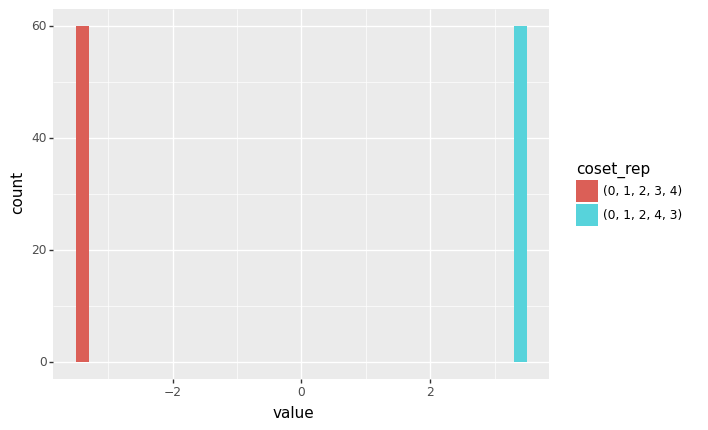

<ggplot: (681121552)>

In [56]:
df = right_base_df.filter(pl.col('variable') == 'dim92').join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), on='permutation')
ggplot(df, aes(x='value', fill='coset_rep')) + geom_histogram(binwidth=0.2)

In [121]:
left_base_df.filter(pl.col('variable') == 'dim100')

layer,permutation,variable,value
str,str,str,f32
"""left_linear""","""(0, 3, 1, 2, 4…","""dim100""",-0.000862
"""left_linear""","""(0, 4, 3, 2, 1…","""dim100""",-0.000862
"""left_linear""","""(1, 0, 3, 2, 4…","""dim100""",-0.000186
"""left_linear""","""(1, 0, 4, 3, 2…","""dim100""",-0.000186
"""left_linear""","""(2, 0, 3, 4, 1…","""dim100""",-0.000354
"""left_linear""","""(2, 1, 3, 0, 4…","""dim100""",-0.000354
"""left_linear""","""(3, 4, 1, 2, 0…","""dim100""",0.000912
"""left_linear""","""(4, 0, 3, 1, 2…","""dim100""",0.00049
"""left_linear""","""(4, 3, 0, 2, 1…","""dim100""",0.000491


/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 7 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim23_s4_plot.png


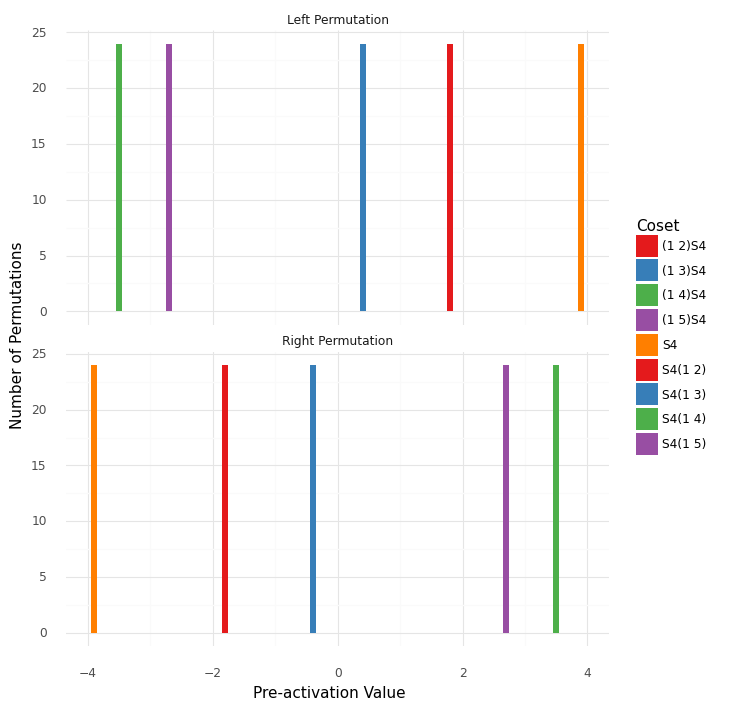

<ggplot: (687945029)>

In [164]:
from plotnine import labs, theme_minimal, theme_linedraw, geom_dotplot, scale_color_manual, scale_fill_manual
from mizani.palettes import brewer_pal


left_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(1, 0, 2, 3, 4)': '(1 2)S4',
    '(1, 2, 0, 3, 4)': '(1 3)S4',
    '(1, 2, 3, 0, 4)': '(1 4)S4',
    '(1, 2, 3, 4, 0)': '(1 5)S4',

}

right_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(1, 0, 2, 3, 4)': 'S4(1 2)',
    '(2, 0, 1, 3, 4)': 'S4(1 3)',
    '(3, 0, 1, 2, 4)': 'S4(1 4)',
    '(4, 0, 1, 2, 3)': 'S4(1 5)'

}


dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(full_right_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(right_coset_rename))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(full_left_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(left_coset_rename))
    
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')

palette = brewer_pal('qual', 6)(5)

colors = palette + palette[:-1]


fig = (
    ggplot(df, aes(x='value', fill='coset_rep')) 
    + geom_histogram(binwidth=0.1) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Coset")
    + theme_minimal()
    + theme(figure_size=(7,8))
    + scale_fill_manual(values = colors)
)

fig.save('s5_40_seed5_dim23_s4_plot.png')
fig

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim23_s4_full_plot.png


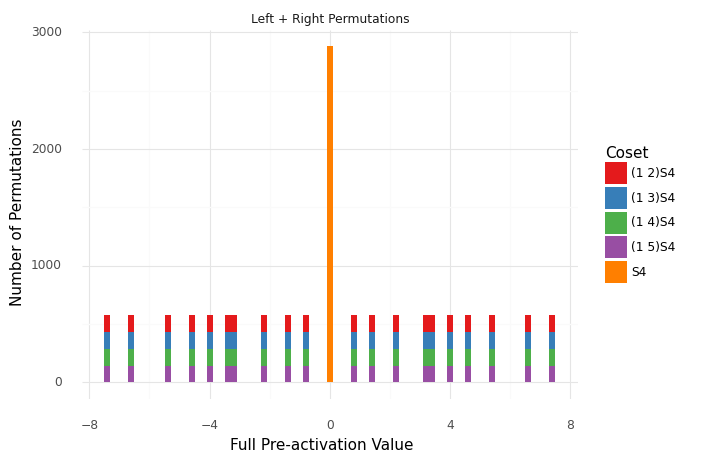

<ggplot: (688294919)>

In [165]:
from plotnine import scale_fill_brewer

dflin = (
    linear_df
    .select(['permutation_target', 'dim23'])
    .join(full_left_coset_df.filter(pl.col('subgroup') == 's4_0'), left_on='permutation_target', right_on='permutation')
    .with_columns(
        #if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'),
        pl.Series('layer', ['Left + Right Permutations']* 14400),
        pl.col('coset_rep').map_dict(left_coset_rename)
    )
)

fig = (
    ggplot(dflin, aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Coset")
    + theme_minimal()
    + scale_fill_brewer(type='qual', palette=6)
)
fig.save('s5_40_seed5_dim23_s4_full_plot.png')
fig

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim23_s4_full_relu_plot.png


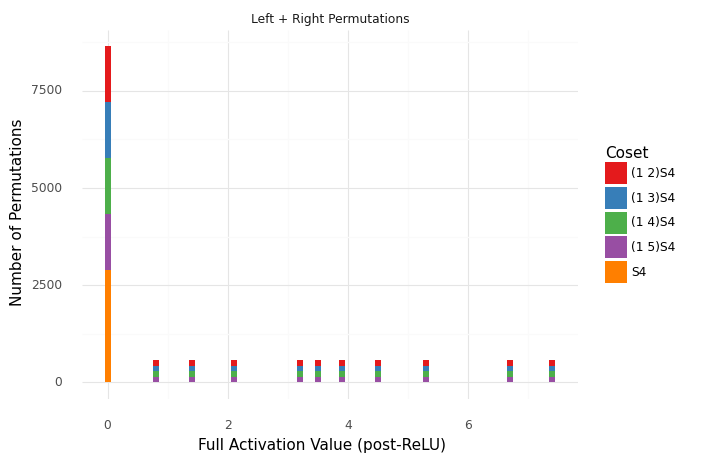

<ggplot: (671250123)>

In [166]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim23').clip_min(0)), aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=0.1)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Activation Value (post-ReLU)", fill="Coset")
    + theme_minimal()
    +  scale_fill_brewer(type='qual', palette=6)
)
fig.save('s5_40_seed5_dim23_s4_full_relu_plot.png')
fig

In [169]:
x = torch.randn((100, 100, 100, 100))
torch.fft.fftn(x).shape

torch.Size([100, 100, 100, 100])

In [143]:
from mizani.palettes import brewer_pal

In [147]:
brewer_pal()()

['#F7FBFF',
 '#DEEBF7',
 '#C6DBEF',
 '#9ECAE1',
 '#6BAED6',
 '#4292C6',
 '#2171B5',
 '#08519C',
 '#08306B']

  0%|          | 0/128 [00:00<?, ?it/s]

In [285]:
merged_w_seed = [df.insert_at_idx(0, pl.Series('seed', [i] * df.shape[0])) for i, df in enumerate(merged_data)]
lr_w_seed = [df.insert_at_idx(0, pl.Series('seed', [i] * df.shape[0])) for i, df in enumerate(lr_data)]

In [286]:
merged_df = pl.concat(merged_w_seed)
lr_df = pl.concat(lr_w_seed)

In [84]:
#merged_df.write_parquet('s5_small_coset_stats.parquet')
#lr_df.write_parquet('s5_small_left_right_cosets.parquet')
merged_df = pl.read_parquet('s5_small_coset_stats.parquet')
lr_df = pl.read_parquet('s5_small_left_right_cosets.parquet')

In [104]:
merged_df.head()

seed,epoch,layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
i64,i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
0,0,"""left_linear""","""dim5""","""a5_0""",0.325513,0.01931,-0.91423,1.275069,0.161517,19.265306,2.015344,"""a5""","""right_linear""","""a5_0""",0.363176,-0.04661,-1.078822,0.967914,0.181016,21.801584,2.006324,"""a5""","""(a5_0, a5_0)""",0.344345,2.010834,20.533445,"""a5"""
0,0,"""left_linear""","""dim14""","""a5_0""",0.356455,-0.029171,-0.981152,0.830798,0.176811,21.142574,2.016027,"""a5""","""right_linear""","""a5_0""",0.274251,-0.001815,-0.779906,0.939263,0.136014,16.186052,2.016345,"""a5""","""(a5_0, a5_0)""",0.315353,2.016186,18.664314,"""a5"""
0,0,"""left_linear""","""dim24""","""a5_0""",0.304858,-0.066634,-0.886384,0.844595,0.151148,18.519444,2.016949,"""a5""","""right_linear""","""a5_0""",0.367453,-0.011444,-1.369133,1.107524,0.193276,23.015509,1.901186,"""a5""","""(a5_0, a5_0)""",0.336156,1.959068,20.767475,"""a5"""
0,0,"""left_linear""","""dim25""","""a5_0""",0.331862,-0.040986,-1.113429,0.984294,0.164617,19.791054,2.015957,"""a5""","""right_linear""","""a5_0""",0.297718,0.01681,-0.979609,1.009379,0.162748,19.4009,1.82932,"""a5""","""(a5_0, a5_0)""",0.31479,1.922639,19.595978,"""a5"""
0,0,"""left_linear""","""dim26""","""a5_0""",0.368412,-0.026045,-0.973703,0.804987,0.184445,22.030352,1.997407,"""a5""","""right_linear""","""a5_0""",0.351523,-0.04382,-1.091406,1.050281,0.174348,20.977892,2.016212,"""a5""","""(a5_0, a5_0)""",0.359967,2.006809,21.504122,"""a5"""


In [110]:
from plotnine import scale_y_log10, labs


sg_names = {
    'a4': 'A4',
    'a5': 'A5',
    'd10': 'D10',
    'frob20': 'Frobenius20',
    's3': 'S3',
    's4': 'S4',
    'twisteds3': 'Twisted S3',
    'z5': 'C5',
    'z6': 'C6'
}

df = (
    merged_df
    #.filter(pl.col('subgroup_class') == 's4')
    .groupby(['seed', 'epoch', 'subgroup_class'])
    .agg(
        mean_two_norm = pl.col('two_norm').mean(),
        min_two_norm = pl.col('two_norm').min(),
        max_two_norm = pl.col('two_norm').max(),
        mean_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('coset_var_ratio').max(),
        full_count = pl.count(),
        count = (pl.col('coset_var_ratio') < 1.0).sum(),
        norm_count = (pl.col('coset_var_ratio') < 1.0).sum() 
    )
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_coset_var_ratio = pl.col('mean_coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('mean_coset_var_ratio').median(),
        coset_var_ratio25 = pl.col('mean_coset_var_ratio').quantile(0.25),
        coset_var_ratio75 = pl.col('mean_coset_var_ratio').quantile(0.75),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('mean_coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('mean_coset_var_ratio').max(),
        full_count = pl.count(),
        count = pl.col('count').mean(),
        norm_count = pl.col('norm_count').mean(),
        norm_count_sd = pl.col('norm_count').std(),
        norm_count50 = pl.col('norm_count').median(),
        norm_count25 = pl.col('norm_count').quantile(0.25),
        norm_count75 = pl.col('norm_count').quantile(0.75)
         
    )
    .filter(pl.col('subgroup_class') != 'mixed')
    .with_columns(pl.col('subgroup_class').map_dict(sg_names))
    .sort(['epoch', 'subgroup_class'])
)
fig = (
    ggplot(
        df,
        aes(
            x = 'epoch',
            y = 'norm_count',
            color = 'subgroup_class',
            fill = 'subgroup_class'
        )
    ) 
    + geom_line() #+ geom_ribbon(alpha=0.25)
    + theme_minimal()
    #    + theme(axis_text_x=element_text(angle=15))
    + labs(
        x = 'Epoch',
        y = 'Mean Number of Coset Circuits',
        title = 'Evolution of Coset Circuits Over Training',
        color='Subgroup',
        fill='Subgroup'
    )
)

In [111]:
fig.save('s5_40_agg_coset_circuits.pdf')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_agg_coset_circuits.pdf


In [ ]:
sg_names = {
    'a4': 'A4',
    'a5': 'A5',
    'd10': 'D10',
    'frob20': 'Frobenius20',
    's3': 'S3',
    's4': 'S4',
    'twisteds3': 'Twisted S3',
    'z5': 'C5',
    'z6': 'C6'
}

df = (
    merged_df
    .filter((pl.col('subgroup_class') == 's4'))
    .groupby(['seed', 'epoch', 'subgroup_pair'])
    .agg(
        mean_two_norm = pl.col('two_norm').mean(),
        min_two_norm = pl.col('two_norm').min(),
        max_two_norm = pl.col('two_norm').max(),
        mean_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('coset_var_ratio').max(),
        full_count = pl.count(),
        count = (pl.col('coset_var_ratio') < 1.0).sum(),
        norm_count = (pl.col('coset_var_ratio') < 1.0).sum() 
    )
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_coset_var_ratio = pl.col('mean_coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('mean_coset_var_ratio').median(),
        coset_var_ratio25 = pl.col('mean_coset_var_ratio').quantile(0.25),
        coset_var_ratio75 = pl.col('mean_coset_var_ratio').quantile(0.75),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('mean_coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('mean_coset_var_ratio').max(),
        full_count = pl.count(),
        count = pl.col('count').mean(),
        norm_count = pl.col('norm_count').mean(),
        norm_count_sd = pl.col('norm_count').std(),
        norm_count50 = pl.col('norm_count').median(),
        norm_count25 = pl.col('norm_count').quantile(0.25),
        norm_count75 = pl.col('norm_count').quantile(0.75)
         
    )
    .filter(pl.col('subgroup_class') != 'mixed')
    .with_columns(pl.col('subgroup_class').map_dict(sg_names))
    .sort(['epoch', 'subgroup_class'])
)
(
    ggplot(
        df,
        aes(
            x = 'epoch',
            y = 'norm_count',
            color = 'subgroup_class',
            fill = 'subgroup_class'
        )
    ) 
    + geom_line() #+ geom_ribbon(alpha=0.25)
    + theme_minimal()
    #    + theme(axis_text_x=element_text(angle=15))
    + labs(
        x = 'Epoch',
        y = 'Mean Number of Coset Circuits',
        title = 'Evolution of Coset Circuits Over Training',
        color='Subgroup',
        fill='Subgroup'
    )
)

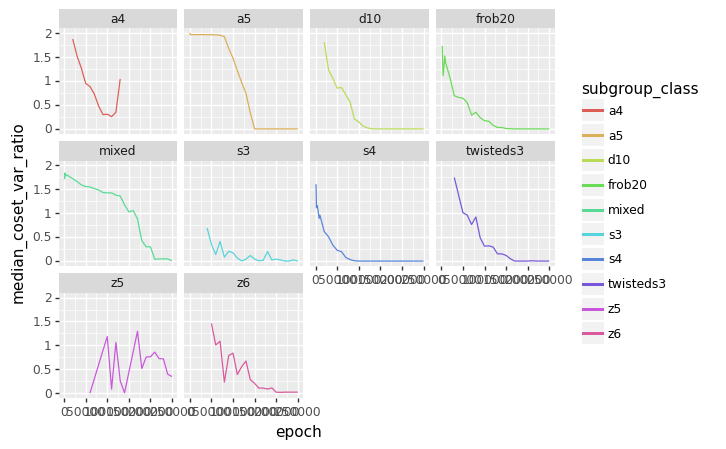

<ggplot: (694628316)>

In [297]:
ggplot(
    df,
    aes(
        x = 'epoch',
        y = 'median_coset_var_ratio',
        ymin = 'coset_var_ratio25',
        ymax = 'coset_var_ratio75',
        fill = 'subgroup_class',
        color='subgroup_class'
    )
) + facet_wrap('~subgroup_class') + geom_line()

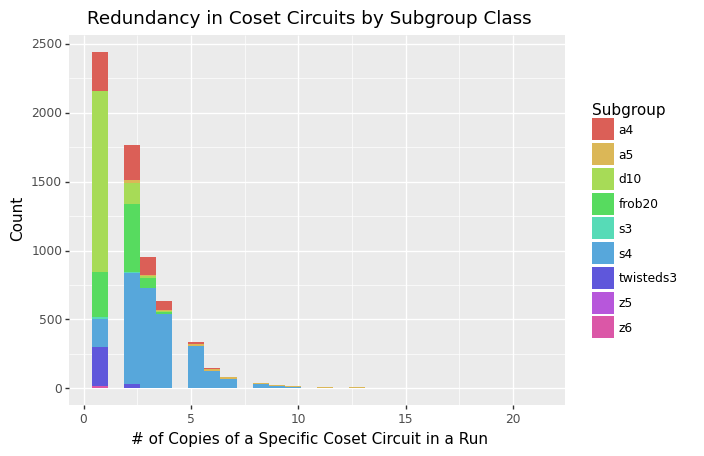

<ggplot: (689439243)>

In [362]:
df = (
    merged_df
    .filter(pl.col('epoch') == 249999)
    .filter(pl.col('coset_var_ratio') < 1.0)
    .filter(pl.col('subgroup_class') != 'mixed')
    .groupby(['seed', 'subgroup_class', 'subgroup_pair'])
    .agg(pl.count())
)

(
    ggplot(df, aes(x = 'count', fill = 'subgroup_class')) 
    + geom_histogram(binwidth=0.75)
    + labs(x = '# of Copies of a Specific Coset Circuit in a Run', y = 'Count', fill = 'Subgroup', title = 'Redundancy in Coset Circuits by Subgroup Class')
)

In [243]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(11)

In [245]:
power_df.filter(pl.col('variable') == 'dim88')

layer,irrep,variable,value
str,str,str,f32
"""left_linear""","""(1, 1, 1, 1, 1…","""dim88""",0.000002
"""left_linear""","""(2, 1, 1, 1)""","""dim88""",0.000014
"""left_linear""","""(2, 2, 1)""","""dim88""",0.000012
"""left_linear""","""(3, 1, 1)""","""dim88""",0.000034
"""left_linear""","""(3, 2)""","""dim88""",0.000024
"""left_linear""","""(4, 1)""","""dim88""",0.985349
"""left_linear""","""(5,)""","""dim88""",0.014565
"""right_linear""","""(1, 1, 1, 1, 1…","""dim88""",4.5266e-12
"""right_linear""","""(2, 1, 1, 1)""","""dim88""",0.000051


In [246]:
df88_left = (
    llinear_df
    .groupby('permutation')
    .agg(preacts=pl.col('dim88').sum())
    .join(full_right_coset_df.filter(pl.col('subgroup').str.starts_with('a4')), on='permutation')
)

df88_right = (
    rlinear_df
    .groupby('permutation')
    .agg(preacts=pl.col('dim88').sum())
    .join(full_left_coset_df.filter(pl.col('subgroup').str.starts_with('a4')), on='permutation')
)


In [249]:
df88_left.head()

permutation,preacts,subgroup,coset_rep
str,f32,str,str
"""(0, 1, 2, 3, 4…",4.251543,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 1, 3, 4, 2…",4.19844,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 1, 4, 2, 3…",4.252069,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 2, 1, 4, 3…",-3.74912,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 2, 3, 1, 4…",-3.754175,"""a4_0""","""(0, 1, 2, 3, 4…"


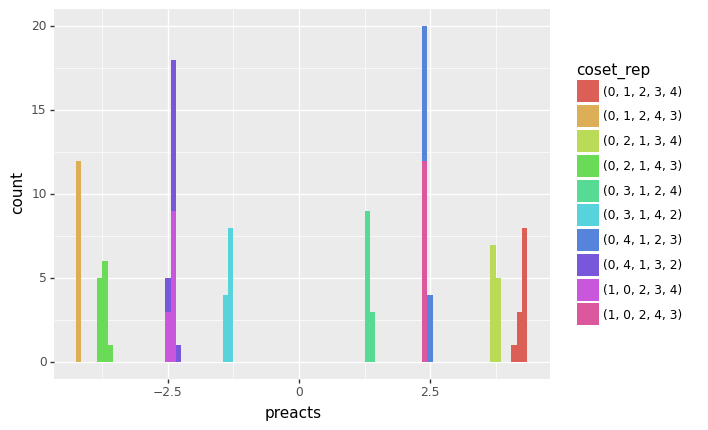

<ggplot: (691295662)>

In [251]:
sg = 1
(
    ggplot(
        df88_left.filter(pl.col('subgroup') == f'a4_{sg}'),
        aes(x = 'preacts', fill = 'coset_rep')
    )
    + geom_histogram(binwidth=0.1)
)

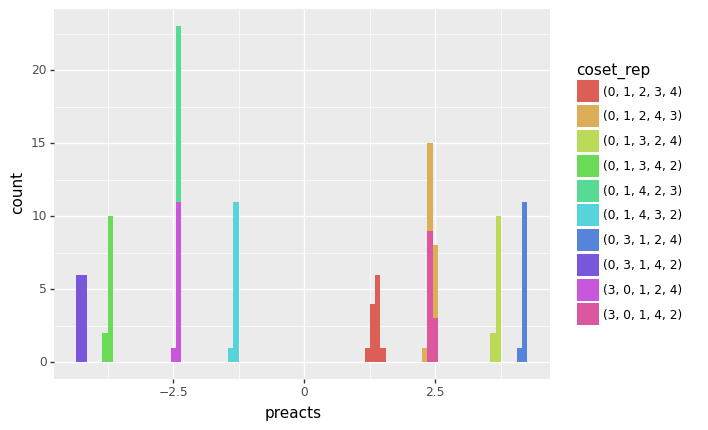

<ggplot: (372549413)>

In [257]:
sg = 3
(
    ggplot(
        df88_right.filter(pl.col('subgroup') == f'a4_{sg}'),
        aes(x = 'preacts', fill = 'coset_rep')
    )
    + geom_histogram(binwidth=0.1)
)

In [213]:
merged0, both0 = cosets_over_time(7)

In [215]:
merged0.filter(pl.col('subgroup_class') == 's3xs2')

epoch,layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
80000,"""left_linear""","""dim58""","""s3xs2_9""",26.159439,-0.067397,-5.729514,6.95602,14.54631,1731.556152,1.798356,"""s3xs2""","""right_linear""","""s3xs2_9""",10.444861,-0.048696,-5.24966,5.754246,13.609639,1619.832031,0.767461,"""s3xs2""","""(s3xs2_9, s3xs…",18.302151,1.282908,1675.694092,"""s3xs2"""
90000,"""left_linear""","""dim58""","""s3xs2_9""",19.449917,-0.080549,-5.88949,5.99918,14.973593,1782.63623,1.298948,"""s3xs2""","""right_linear""","""s3xs2_9""",7.999158,-0.073104,-5.163314,5.889448,14.36675,1710.28418,0.556783,"""s3xs2""","""(s3xs2_9, s3xs…",13.724538,0.927865,1746.460205,"""s3xs2"""
100000,"""left_linear""","""dim58""","""s3xs2_9""",15.323632,-0.02296,-5.909278,5.683478,16.219231,1930.151978,0.944782,"""s3xs2""","""right_linear""","""s3xs2_9""",5.86724,-0.082841,-5.384318,5.941888,16.01652,1906.789429,0.366324,"""s3xs2""","""(s3xs2_9, s3xs…",10.595436,0.655553,1918.470703,"""s3xs2"""
110000,"""left_linear""","""dim58""","""s3xs2_9""",14.176,0.043123,-6.167743,6.125372,17.599018,2094.506104,0.805499,"""s3xs2""","""right_linear""","""s3xs2_9""",4.721634,-0.022828,-5.786691,6.543193,17.222828,2049.579102,0.27415,"""s3xs2""","""(s3xs2_9, s3xs…",9.448816,0.539825,2072.04248,"""s3xs2"""
120000,"""left_linear""","""dim58""","""s3xs2_9""",14.2924,-0.011542,-6.571354,6.296471,19.017447,2263.091797,0.751541,"""s3xs2""","""right_linear""","""s3xs2_9""",4.775422,-0.000159,-6.001236,6.693977,18.771845,2233.849365,0.254393,"""s3xs2""","""(s3xs2_9, s3xs…",9.533911,0.502967,2248.470703,"""s3xs2"""
130000,"""left_linear""","""dim20""","""s3xs2_0""",9.149903,-0.266361,-4.886692,6.503676,11.160444,1336.606689,0.819851,"""s3xs2""","""right_linear""","""s3xs2_0""",18.983082,-0.4942,-6.118483,7.04597,11.04547,1343.718872,1.71863,"""s3xs2""","""(s3xs2_0, s3xs…",14.066492,1.269241,1340.162842,"""s3xs2"""
130000,"""left_linear""","""dim45""","""s3xs2_2""",22.493971,0.061129,-4.836559,5.196066,11.545407,1374.352173,1.948305,"""s3xs2""","""right_linear""","""s3xs2_9""",4.329961,0.129929,-5.552782,6.122554,12.672289,1510.027954,0.341687,"""s3xs2""","""(s3xs2_2, s3xs…",13.411966,1.144996,1442.190063,"""s3xs2"""
130000,"""left_linear""","""dim17""","""s3xs2_2""",15.229809,0.065505,-4.783784,6.71604,9.815942,1168.611816,1.551538,"""s3xs2""","""right_linear""","""s3xs2_9""",16.544222,0.023972,-5.362032,4.824189,9.268164,1102.980591,1.785059,"""s3xs2""","""(s3xs2_2, s3xs…",15.887015,1.668299,1135.796143,"""s3xs2"""
130000,"""left_linear""","""dim118""","""s3xs2_9""",11.131682,0.165891,-4.975421,5.688489,10.648034,1270.418579,1.045421,"""s3xs2""","""right_linear""","""s3xs2_7""",12.264299,-0.088452,-4.785831,5.68211,9.279283,1105.173462,1.321686,"""s3xs2""","""(s3xs2_9, s3xs…",11.69799,1.183554,1187.796021,"""s3xs2"""


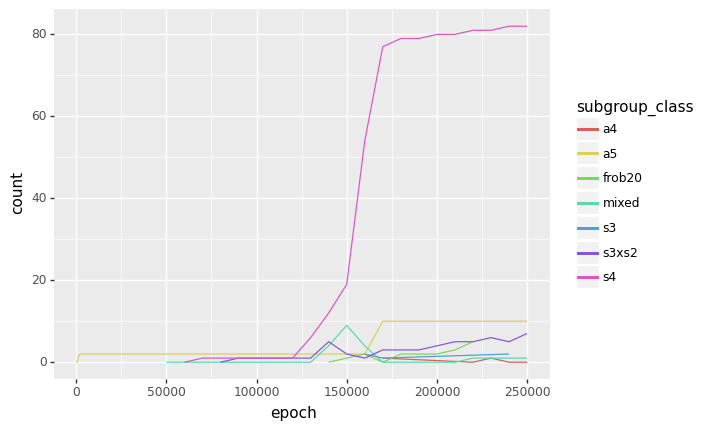

<ggplot: (689260986)>

In [217]:
from plotnine import scale_y_log10

df = (
    merged_df
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_two_norm = pl.col('two_norm').mean(),
        min_two_norm = pl.col('two_norm').min(),
        max_two_norm = pl.col('two_norm').max(),
        mean_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('coset_var_ratio').max(),
        full_count = pl.count(),
        count = (pl.col('coset_var_ratio') < 1.0).sum()
    )
    .sort(['epoch', 'subgroup_class'])
)
ggplot(
    df,
    aes(
        x = 'epoch',
        y = 'count',
        color = 'subgroup_class')
) + geom_line()

In [78]:

"""
(
    linear_coset_df
    .groupby('subgroup_pair')
    .agg([
        pl.count(),
        pl.col('coset_var').mean(),
        pl.col('coset_var_ratio').mean(),
        pl.col('coset_var').min().suffix('_min'),
        pl.col('coset_var').max().suffix('_max'),
        pl.col('coset_var_ratio').min().suffix('_min'),
        pl.col('coset_var_ratio').max().suffix('_max'),
        pl.col('two_norm').mean(),
        (pl.col('two_norm') < 1.0).sum().alias('num_tiny'),
        (pl.col('two_norm') < 15.0).sum().alias('num_small')
    ]).sort('subgroup_pair')
)
"""
linear_coset_df.head()

variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
"""dim93""","""a5_0""",3.8016e-8,0.000007,-1.671376,1.671549,2.816196,335.12738,1.3499e-8,"""a5""","""a5_0""",0.001393,-0.002718,-1.671691,1.671575,2.788444,331.825745,0.0005,"""a5""","""(a5_0, a5_0)""",0.000697,0.00025,333.476562,"""a5"""
"""dim102""","""a5_0""",0.231451,0.000084,-0.709306,0.709774,0.122205,14.542413,1.893958,"""a5""","""a5_0""",0.231134,-0.000156,-0.709388,0.709617,0.122003,14.518321,1.894499,"""a5""","""(a5_0, a5_0)""",0.231293,1.894229,14.530367,"""a5"""
"""dim8""","""a5_0""",2.5227e-14,1.0589e-11,-3.0799e-7,3.1268e-7,1.5306e-14,1.8214e-12,1.648231,"""a5""","""a5_0""",2.9042e-14,1.0940e-10,-2.7550e-7,3.0962e-7,1.7090e-14,2.0337e-12,1.699406,"""a5""","""(a5_0, a5_0)""",2.7135e-14,1.673818,1.9275e-12,"""a5"""
"""dim32""","""a5_0""",0.233722,0.000084,-0.712797,0.713259,0.123405,14.68522,1.893936,"""a5""","""a5_0""",0.233405,-0.000157,-0.712884,0.713085,0.123201,14.660967,1.894498,"""a5""","""(a5_0, a5_0)""",0.233563,1.894217,14.673094,"""a5"""
"""dim33""","""a5_0""",3.8886e-8,0.000007,-1.671209,1.6714,2.815616,335.05838,1.3811e-8,"""a5""","""a5_0""",0.001393,-0.002718,-1.671448,1.671346,2.787811,331.750336,0.0005,"""a5""","""(a5_0, a5_0)""",0.000696,0.00025,333.404358,"""a5"""


In [90]:
exp_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')

paths = sorted([fp for fp in exp_dir.glob('s5_40_0/*.pth')], key=fp_key)

In [97]:
ckpt0 = torch.load('/Users/dashiell/workspace/sn-grok/s5_40_small/s5_40_0/full_run.pth', map_location=torch.device('cpu'))

In [99]:
ckpt0['checkpoint_epochs']

[0,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 512,
 1024,
 2048,
 4096,
 8192,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 110000,
 120000,
 130000,
 140000,
 150000,
 160000,
 170000,
 180000,
 190000,
 200000,
 210000,
 220000,
 230000,
 240000]

In [52]:
right_perm_coset_df.groupby('subgroup').agg([pl.count(), pl.col('min_coset_var').mean()]).sort('subgroup')

subgroup,count,min_coset_var
str,u32,f32
"""a5_0""",12,0.039933
"""frob20_0""",15,0.000524
"""frob20_3""",15,0.000072
"""frob20_4""",13,0.000048
"""frob20_5""",12,0.000145
"""s4_0""",12,0.017821
"""s4_1""",12,0.019676
"""s4_2""",10,0.036945
"""s4_3""",10,0.035601


In [107]:
left_perm_coset_df = left_perm_coset_df.select(pl.exclude(['layer', 'sanity'])).rename({
    'subgroup': 'left_subgroup',
    'min_coset_var': 'left_min_coset_var',
})

right_perm_coset_df = right_perm_coset_df.select(pl.exclude(['layer', 'sanity'])).rename({
    'subgroup': 'right_subgroup',
    'min_coset_var': 'right_min_coset_var',
})

In [116]:
linear_coset_df = (
    left_perm_coset_df
    .join(right_perm_coset_df, on='variable', how='inner')
    .with_columns([
        ('(' + pl.col('left_subgroup') + ', ' + pl.col('right_subgroup') + ')').alias('subgroup_pair'),
        ((pl.col('left_min_coset_var') + pl.col('right_min_coset_var'))/ 2).alias('coset_var')
    ]).sort('subgroup_pair')
)
linear_coset_df.groupby('subgroup_pair').agg([pl.count(), pl.col('coset_var').mean()]).sort('count')

subgroup_pair,count,coset_var
str,u32,f32
"""(a4_3, a4_4)""",1,0.003119
"""(s4_0, s4_3)""",2,0.017964
"""(frob20_1, fro...",2,0.000026
"""(frob20_4, fro...",2,0.000328
"""(frob20_4, fro...",2,0.000074
"""(a4_2, a4_4)""",2,0.003119
"""(frob20_5, fro...",2,0.000026
"""(frob20_1, fro...",2,0.000316
"""(s4_1, s4_4)""",2,0.004579


In [80]:
from plotnine import geom_dotplot

df_left = (
    llinear_df
    .filter((pl.col('irrep') == '(3, 2)'))
    .join(frob_right_coset_df, on='permutation')
)

df_right = (
    rlinear_df
    .filter((pl.col('irrep') == '(3, 2)'))
    .join(frob_left_coset_df, on='permutation')
)




In [83]:
df_right.head()

layer,permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,...,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127,subgroup,coset_rep
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str
"""right_linear""","""(0, 1, 3, 4, 2...","""(3, 2)""",0.006882,4.057464,-2.206739,0.010841,-4.289482,-3.237722,-0.050637,-0.01471,-1.7615e-8,0.01364,0.007057,-0.150332,-0.015372,2.186669,-0.049615,-0.554121,0.548133,0.004062,-0.001372,0.014201,-0.268502,0.004001,-0.003255,-4.302774,-4.267099,0.003995,-0.014742,-3.240087,-0.268333,0.536571,0.267557,-0.023176,-0.370521,-0.004803,...,-0.004822,-0.273449,0.544868,0.013992,4.280837,4.21802,0.014369,-4.246798,-0.006351,-0.368739,-0.002207,-0.0145,0.004205,-4.242894,4.292915,0.014659,-0.011246,-0.150367,-0.004831,-0.556363,-0.049622,0.26684,0.028603,0.028469,-2.210442,0.266235,-0.538237,2.188267,-0.272615,0.02742,-0.303674,0.265815,0.014382,-0.011194,-0.014577,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(0, 2, 4, 1, 3...","""(3, 2)""",-0.037603,-0.510325,2.242348,0.012491,0.539522,0.407217,-0.041672,0.037869,6.9398e-8,0.016964,0.02117,-0.15108,-0.017843,-2.222107,-0.040672,-2.247108,2.223311,-0.02367,0.000418,-0.03678,-0.269868,-0.023635,0.019024,0.541243,0.536768,-0.023651,-0.017586,0.407598,-0.269708,2.176932,0.268935,-0.034167,0.226574,-0.014371,...,-0.01438,-0.275064,2.209905,-0.036834,-0.538542,-0.530522,0.017549,0.534117,0.034558,0.225479,0.000673,0.037417,-0.022088,0.533925,-0.539909,0.016992,-0.013481,-0.151138,-0.01437,-2.256732,-0.040652,0.268042,0.041538,0.041608,2.246116,0.267636,-2.183012,-2.223598,-0.273919,0.041143,-1.231927,0.266899,-0.037679,-0.013487,0.036949,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(0, 3, 1, 2, 4...","""(3, 2)""",0.010143,-2.07014,4.313056,0.018207,2.189115,1.651885,-0.001583,0.055646,8.7130e-9,0.024405,0.038649,-0.148956,-0.026223,-4.274526,-0.001417,2.284118,-2.260237,0.006364,0.001084,-0.054335,-0.266122,0.006416,-0.005263,2.19541,2.177217,0.006435,-0.025799,1.653124,-0.265701,-2.212847,0.264838,-0.007069,-0.029427,-0.026318,...,-0.026305,-0.271105,-2.24646,-0.053928,-2.184457,-2.152412,0.025736,2.166969,-0.009507,-0.029246,0.001743,0.05504,0.005752,2.165074,-2.190606,0.02603,-0.019813,-0.149066,-0.026287,2.294101,-0.00108,0.264506,0.008761,0.00892,4.320537,0.263929,2.219194,-4.277344,-0.270141,0.008272,1.252382,0.263046,-0.054901,-0.019865,0.054662,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(0, 4, 2, 3, 1...","""(3, 2)""",-0.01495,2.106131,-0.546386,-0.00417,-2.225807,-1.68041,-0.028023,0.050516,-9.1096e-8,-0.006098,-0.005069,-0.153995,0.00613,0.541256,-0.027306,4.402717,-4.356461,-0.009286,-0.000655,-0.049179,-0.275045,-0.009346,0.008119,-2.232992,-2.214566,-0.009319,0.005927,-1.681707,-0.274763,-4.265129,0.274039,-0.009227,-0.626638,0.003442,...,0.003469,-0.280252,-4.330182,-0.049171,2.221492,2.188954,-0.006494,-2.20404,0.013741,-0.623577,-0.001055,0.049957,-0.008917,-2.201888,2.227732,-0.006277,0.004823,-0.154083,0.003461,4.42166,-0.027564,0.273533,0.010924,0.011153,-0.547218,0.272637,4.277411,0.541908,-0.279316,0.010546,2.413643,0.272224,-0.050063,0.004818,0.049781,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(1, 0, 2, 4, 3...","""(3, 2)""",-0.010336,4.059891,-0.544168,0.027504,-4.291996,-3.239558,-0.00045,0.037673,3.3039e-8,0.036479,0.0088,-0.152333,-0.03987,0.538739,0.000318,-2.247093,2.22347,-0.006535,-0.001159,

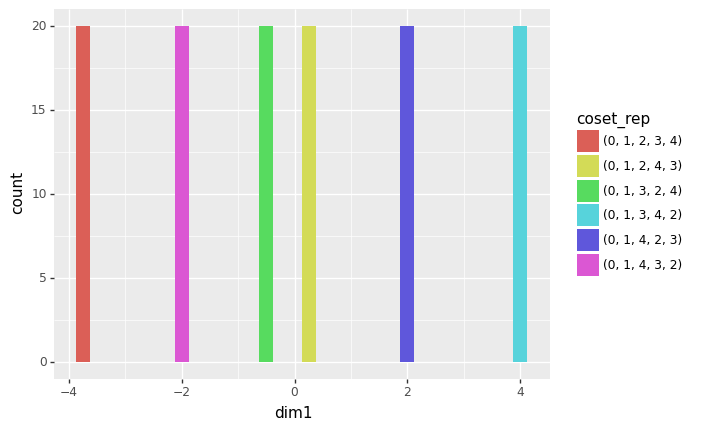

<ggplot: (691736622)>

In [91]:
coset = 4
# 123, 19, 18, 33, 3, 56
col = 'dim1'

#  geom_dotplot(binwidth=0.1, binpositions='all', stackgroups=True)
ggplot(df_right.filter(pl.col('subgroup') == f'frob20_{coset}'), aes(x = col, fill = "coset_rep")) + geom_histogram(binwidth=0.25)

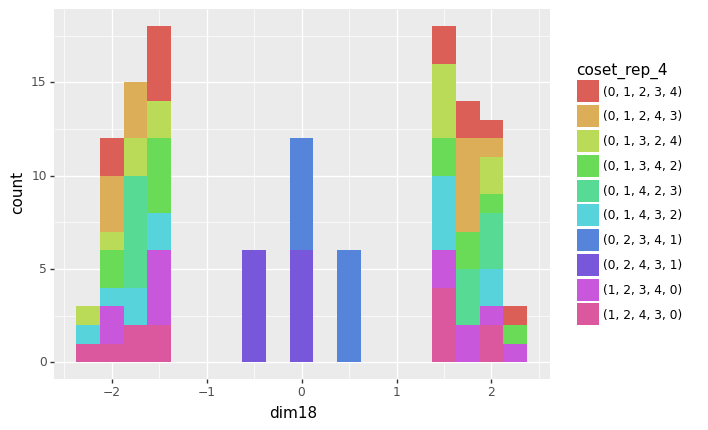

<ggplot: (710019574)>

In [187]:
coset = 4
# 123, 19, 18, 33, 3, 56
col = 'dim18'

#  geom_dotplot(binwidth=0.1, binpositions='all', stackgroups=True)
ggplot(df_left, aes(x = col, fill = f'coset_rep_{coset}')) + geom_histogram(binwidth=0.25)

In [195]:
ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
run_name = f's5_40_7'

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)


original_loss = loss_fn(logits, targets).mean()
    
linear_acts = cache['hook_linear']

linear_acts_df = pl.concat(
    [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])],
    how='horizontal'
)


linear_acts_df.head()

permutation_left,permutation_right,permutation_target,index_left,index_right,index_target,in_train,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,…,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,i64,i64,i64,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…",0,0,0,0,-5.4048e-35,9.7254e-34,-1.4585e-34,-2.6163e-34,0.793983,3.445494,4.3203e-35,2.159479,8.784583,-0.000334,1.5277e-33,-7.6824e-35,1.0233e-29,5.2146e-34,-1.233348,-0.000516,-8.3862e-35,0.000675,-2.7751e-34,1.589495,5.524645,-2.380452,-1.376954,-2.456835,0.0005,-2.510927,-2.5298e-26,-3.07365,2.8666e-35,-4.735275,…,10.837394,-3.075089,-8.866694,-4.972569,1.6400e-35,-1.637271,5.309939,-1.11593,2.514609,1.4504e-34,-2.376213,4.366046,-0.000183,-0.000286,-3.074142,5.776958,-4.0034e-16,-3.074549,-9.1601e-10,2.512307,3.1257e-34,3.0373e-34,-8.7928e-35,1.4787e-34,1.026566,-0.000042,5.440686,2.623858,-0.630295,1.874033,0.000036,0.000944,1.907442,0.001138,1.1363e-33,1.5200e-12,3.311396
"""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…","""(0, 1, 3, 4, 2…",0,1,1,1,1.2939e-33,2.7540e-34,-2.4510e-33,7.9404e-34,5.575815,3.445731,-1.1634e-34,2.159457,9.649538,-0.00065,1.2999e-37,-1.5765e-33,3.6779e-26,-5.1902e-34,6.19338,-3.896802,-4.3737e-34,-1.191763,-7.4705e-35,1.589327,7.52071,-2.380085,-1.377036,-2.456877,0.000179,1.347486,-2.4413e-26,-3.073699,-1.7289e-35,-7.224715,…,3.089146,-3.075087,-8.867555,-0.000568,4.7781e-35,0.000378,0.001183,-4.400392,0.000395,-1.9704e-34,0.001145,4.365889,0.000326,2.879695,-3.074145,5.776776,-2.9294e-16,-3.074578,-9.1618e-10,0.000303,7.8491e-34,2.3084e-33,-3.6606e-34,-3.2855e-35,-4.67418,2.468961,3.822044,0.000469,-0.629977,-2.92777,-6.245067,0.000372,3.191773,-6.355077,4.9990e-34,6.0697e-13,3.311658
"""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…","""(0, 1, 4, 2, 3…",0,2,2,1,2.0865e-33,-1.5691e-34,-3.9370e-33,7.9737e-34,-3.483204,3.445459,-3.8207e-34,2.160563,5.604283,-0.000386,1.7522e-33,-2.2866e-33,5.5711e-26,2.1254e-35,2.564,2.620499,-8.6749e-34,0.217073,-5.1212e-35,1.5892,1.354122,-2.380226,-1.37677,-2.456651,0.000366,-0.000357,-2.3122e-26,-3.073545,-4.1684e-35,-1.304696,…,7.824192,-3.074984,-8.866887,3.266674,2.5361e-34,3.138983,3.44803,-0.000596,3.813981,-1.1125e-33,-6.036894,4.366138,0.000061,-4.627254,-3.074035,5.777158,-2.4758e-16,-3.074516,-9.1599e-10,3.809982,-1.6422e-33,7.5334e-34,-5.9756e-34,4.0977e-34,-2.423145,6.165795,0.658792,-3.876454,-0.630055,-0.000355,-3.764735,0.000569,1.2218,-2.460717,8.3007e-34,9.1805e-13,3.311641
"""(0, 1, 2, 3, 4…","""(0, 2, 1, 4, 3…","""(0, 2, 1, 4, 3…",0,3,3,0,9.4321e-34,3.8127e-34,-2.0282e-33,-4.1884e-34,5.575428,8.464813,-4.3108e-34,2.15874,9.648479,-4.929662,1.1688e-34,-4.6351e-34,1.4812e-30,-8.0769e-34,2.564165,-3.896,-1.2091e-33,0.216824,1.1300e-35,1.589971,7.518509,4.672651,-4.716071,-5.410419,0.000034,-0.000399,8.2658e-27,-3.073434,-4.3692e-35,-7.224184,…,7.82374,-3.074832,-10.66352,-7.901401,3.2992e-34,3.678385,3.447791,-4.400736,0.000289,-1.1716e-33,0.0005,4.365342,2.90143,2.878928,-3.073873,5.777173,-4.0031e-16,-3.074312,3.1480e-13,0.000264,1.3255e-33,2.2820e-33,-6.8797e-34,6.7609e-34,-2.423883,4.864617,0.000406,-2.389576,-0.630331,-0.000385,-3.764714,0.000884,1.061531,-2.460767,-4.6661e-35,-1.0904e-13,3.311051
"""(0, 1, 2, 3, 4…","""(0, 2, 3, 1, 4…","""(0, 2, 3, 1, 4…",0,4,4,0,-2.6110e-34,9.7852e-34,4.6323e-35,1.0777e-33,0.79387,2.099363,-1.9892e-34,2.160378,8.784656,0.810224,3.6605e-33,-2.1213e-33,5.5714e-26,

In [199]:
def get_index_of(col_name, element):
    return (
        pl.col(col_name)
        .list.eval((pl.element() == element).cast(pl.UInt32))
        .list.arg_max().cast(pl.Utf8)
    )

S5 = Permutation.full_group(5)

perms = [str(p) for p in S5]
parities = ['odd' if p.parity else 'even' for p in S5]

parity_df = pl.DataFrame({'permutation': perms, 'parity': parities})

In [200]:
preacts_df = (
    linear_acts_df
    .join(parity_df, left_on='permutation_target', right_on='permutation', how='inner')
    .with_columns([
            pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').list.get(0).alias('val_at_index_0'),
        pl.col('target_vals').list.get(1).alias('val_at_index_1'),
        pl.col('target_vals').list.get(2).alias('val_at_index_2'),
        pl.col('target_vals').list.get(3).alias('val_at_index_3'),
        pl.col('target_vals').list.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

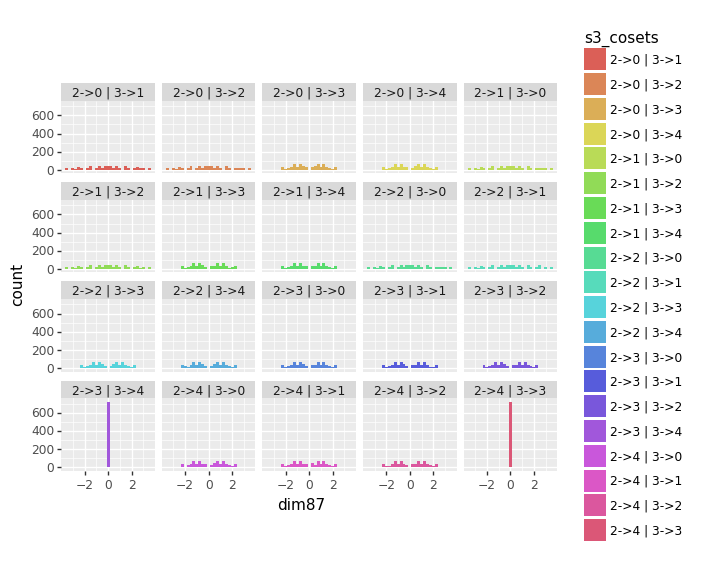

<ggplot: (372390330)>

In [259]:
idx0 = 2
idx1 = 3
# 123, 19, 18, 33, 3, 56
col = 'dim87'

df = preacts_df.with_columns(s3_cosets=(f'{idx0}->' + pl.col(f'index_of_{idx0}') + ' | ' + f'{idx1}->' + pl.col(f'index_of_{idx1}') ))

ggplot(
    df, 
    aes(x = col,
    fill = 's3_cosets')
) + geom_histogram(binwidth=0.25) + facet_wrap('~s3_cosets')

In [528]:
df_left = (
    llinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

df_right = (
    rlinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

In [559]:
from plotnine import scale_y_continuous, scale_x_continuous, theme_minimal, labs

coset = 1
# 123, 19, 18, 33, 3, 56
col = 'dim0'

left_perms = (
    ggplot(
        df_left, 
        aes(x = col, fill = f'val_at_index_{coset}', color=f'val_at_index_{coset}')
    ) 
    + geom_dotplot(binwidth=0.2, binpositions='all', stackgroups=True) 
    + scale_y_continuous(breaks=None)
    + theme_minimal()
    + labs(y = None, x = 'Left Permutation Preactivation', fill = 'Coset (Index of 1)', color = 'Coset (Index of 1)')
    
)

In [558]:
coset = 4
# 123, 19, 18, 33, 3, 56
col = 'dim0'

right_perms = (
    ggplot(
        df_right, 
        aes(x = col, fill = f'index_of_{coset}', color=f'index_of_{coset}')
    ) 
    + geom_dotplot(binwidth=0.2, binpositions='all', stackgroups=True, stackdir='center') 
    + scale_y_continuous(breaks=None)
    + labs(color='Coset (Index of 4)', fill = 'Coset (Index of 4)', y=None, x='Right Permutation Preactivation')
    + theme_minimal()
    
)

In [544]:
preacts_df.head()

permutation_left,permutation_right,permutation_target,index_left,index_right,index_target,in_train,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,...,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127,parity,target_vals,val_at_index_0,val_at_index_1,val_at_index_2,val_at_index_3,val_at_index_4,index_of_0,index_of_1,index_of_2,index_of_3,index_of_4
str,str,str,i64,i64,i64,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,list[str],str,str,str,str,str,str,str,str,str,str
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",0,0,0,1,-3.775655,-1.767592,4.355852,4.111899,3.517007,1.410858,3.370195,-0.002002,-3.3831e-8,3.363332,-0.0002,-0.934809,3.97328,1.958984,-1.674349,1.920292,-0.000007,0.771,0.002141,3.410779,0.817648,0.771271,-2.333777,0.000256,4.300687,0.771408,-1.506821,1.412014,2.803263,4.38824,...,0.003445,-6.125187,-1.128799,8.255993,-3.520589,-0.000898,-2.720912,-0.935056,3.342669,-1.698712,0.000324,3.544459,-0.001003,-9.539651,-0.000851,-0.809453,0.000502,4.022834,0.00078,-2.205838,-3.645307,-2.773485,6.116683,-2.720226,-8.513103,"""even""","[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",0,1,1,0,-8.352973,6.128013,1.883399,4.112237,-4.830398,-4.889877,2.409234,5.262263,-9.3724e-8,3.363966,-0.00043,-1.39209,3.971798,4.408011,-2.61375,3.610363,-1.673557,-2.081377,-0.000401,-1.733583,0.000825,-2.0817,0.000029,-8.372513,-4.002901,-2.082013,-1.506629,-4.893286,1.987334,2.750452,...,-0.000645,-0.909551,-3.853227,-0.001187,4.833428,-0.000575,-2.720825,-1.392542,3.342562,-0.000475,-0.943169,4.356119,0.000508,-9.540128,-2.47641,-0.000452,1.64337,6.474334,-0.827242,-2.207636,-2.718409,-1.966163,0.909722,-2.720075,-3.343327,"""even""","[""0"", ""1"", ... ""2""]","""0""","""1""","""3""","""4""","""2""","""0""","""1""","""4""","""2""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",0,2,2,0,-1.877807,4.17584,3.54388,4.112227,-2.765872,-3.332563,8.509821,6.17964,1.1265e-8,3.364374,-0.000657,0.000097,3.971361,2.763032,3.350292,4.43696,-2.491367,1.953474,0.000292,-2.633646,2.486914,1.953875,-3.301216,-6.30288,-1.950286,1.95421,-1.507692,-3.334889,4.47311,1.949587,...,0.000469,0.000199,-0.000032,2.040124,2.768884,-0.000287,-2.72138,0.000027,3.342789,0.829193,5.049911,1.884051,0.000293,-9.54,-0.812995,-2.46572,2.446318,4.827237,1.69467,-2.206436,-2.264988,-4.425918,0.00069,-2.720561,-2.439587,"""even""","[""0"", ""1"", ... ""3""]","""0""","""1""","""4""","""2""","""3""","""0""","""1""","""3""","""4""","""2"""
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",0,3,3,0,-8.3527,-1.767099,4.356258,4.112339,3.51669,1.410615,0.172352,6.177874,-1.6761e-7,3.362907,-0.000016,-2.505215,3.972086,1.958751,-4.797577,8.568703,-6.578782,-2.082141,0.002001,-2.630355,-1.98739,-2.082396,0.000202,-0.000159,4.300662,-2.082659,-1.506696,1.411745,0.000022,-2.052518,...,0.003219,-0.001071,-3.853646,8.255783,-3.519717,-0.000879,-2.720855,-2.505965,3.34255,4.977879,-3.141994,6.333035,2.226625,-7.301528,-0.000841,1.970553,6.460036,4.023306,-2.843801,0.002369,-0.000579,0.000374,0.001918,-2.720211,-2.441924,"""even""","[""0"", ""2"", ... ""3""]","""0""","""2""","""1""","""4""","""3""","""0""","""2""","""1""","""4""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(0, 2, 3, 1, 4...",0,4,4,1,-3.77538,4.177586,3.54405,4.112895,-2.767575,-3.333015,0.000009,5.265954,-2.7721e-8,3.363995,0.044699,-3.677078,3.970941,2.762717,-4.967926,-0.000261,1.900325,0.770893,0.000394

In [557]:
coset = 4
all_perms = (
    ggplot(
        preacts_df, 
        aes(x = col, fill = f'index_of_{coset}')
    ) 
    + geom_histogram(binwidth=0.5)
    + labs(x = 'Full Preactivations', y = '# of Permutations', fill = 'Coset (Index of 4)')
    + theme_minimal()
)




In [562]:
import patchworklib as pw

p_left = pw.load_ggplot(left_perms, figsize = (2, 2))
p_right = pw.load_ggplot(right_perms, figsize = (2, 2))
p_full = pw.load_ggplot(all_perms, figsize = (4, 4))


PlotnineError: "Could not evaluate the 'x' mapping: 'dim0' (original error: name 'dim0' is not defined)"

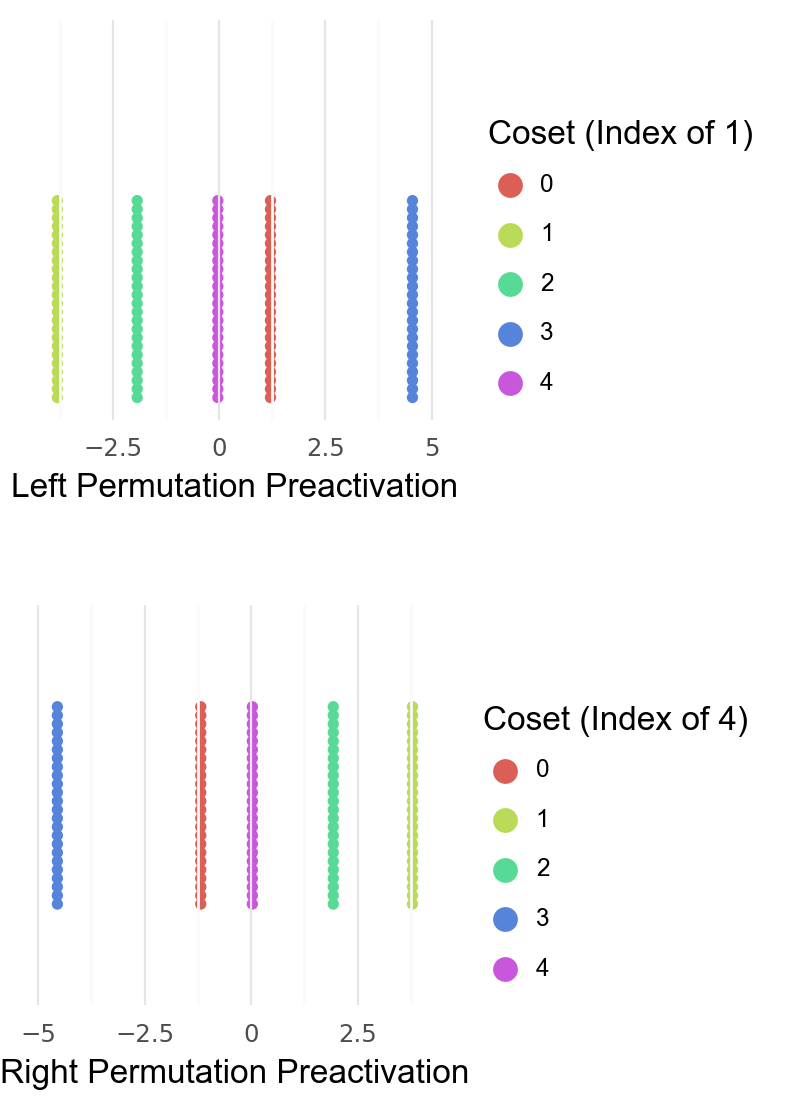

In [564]:
p_left / p_right

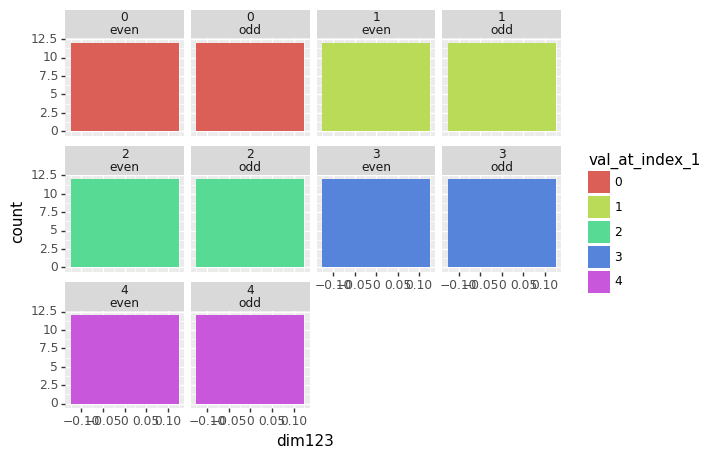

<ggplot: (711382779)>

In [489]:
coset = 1
# 123, 19, 18, 33, 3, 56
col = 'dim123'

ggplot(
    df_right,
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=0.25) + facet_wrap(f'~val_at_index_{coset}+parity')

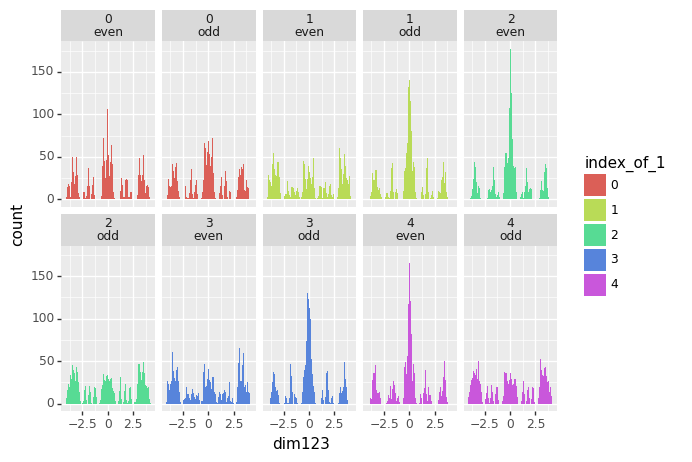

<ggplot: (705860188)>

In [262]:
coset = 1
# 123, 19, 18, 33, 3, 56
col = 'dim123'

ggplot(
    preacts_df, 
    aes(x = col,
    fill = f'index_of_{coset}')) + geom_histogram(binwidth=0.1) + facet_wrap(f'~index_of_{coset}+parity', ncol=5)

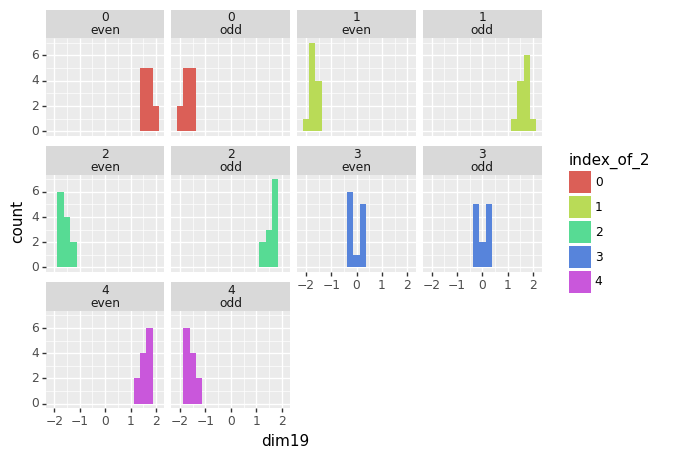

<ggplot: (706154614)>

In [271]:
coset = 2
# 123, 19, 18, 33, 3, 56
col = 'dim19'

ggplot(
    df_left, 
    aes(x = col,
    fill = f'index_of_{coset}')
) + geom_histogram(binwidth=0.25) + facet_wrap(f'~index_of_{coset}+parity')

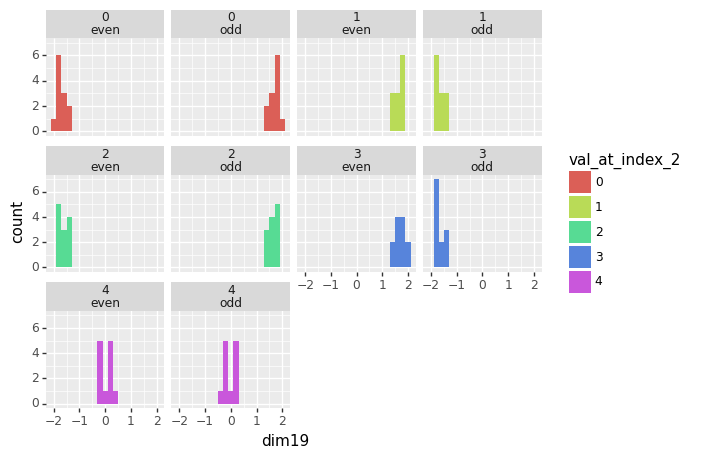

<ggplot: (704855737)>

In [277]:
coset = 2
# 123, 19, 18, 33, 3, 56
col = 'dim19'

ggplot(
    df_right, 
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=0.2) + facet_wrap(f'~val_at_index_{coset}+parity')

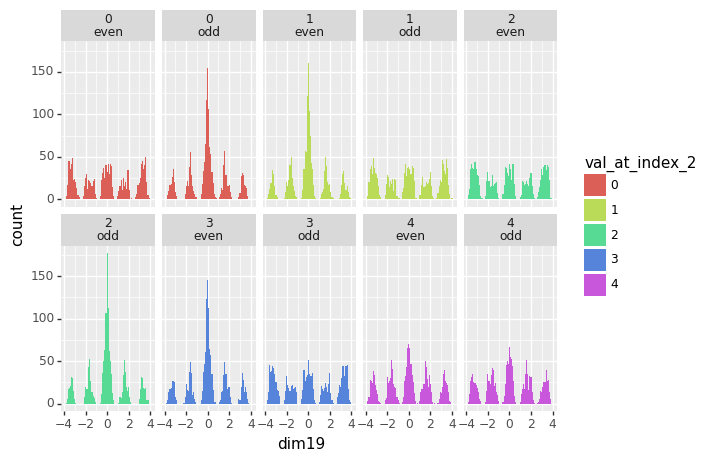

<ggplot: (711317679)>

In [279]:
coset = 2
# 123, 19, 18, 33, 3, 56
col = 'dim19'

ggplot(
    preacts_df, 
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=0.1) + facet_wrap(f'~val_at_index_{coset}+parity', ncol=5)

In [280]:
df2111_left = (
    llinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

df2111_right = (
    rlinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

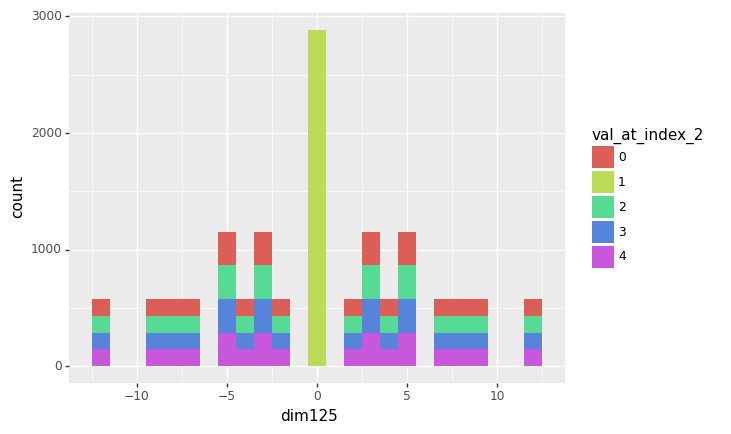

<ggplot: (708607883)>

In [302]:
coset = 2
# 8, 125, 59
col = 'dim125'

ggplot(
    preacts_df, 
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=1) 